In [1]:
#!/usr/bin/env python
# coding: utf-8

import enlighten
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt

from os.path import join, exists
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import Normalizer, StandardScaler

from scipy.stats import pearsonr, pointbiserialr, spearmanr, ttest_ind, chi2_contingency
from sklearn.cluster import SpectralBiclustering
#from utils import jili_sidak_mc, plot_brains, assign_region_names
#from sklearn.linear_model import LinearRegression

from nilearn import datasets, surface, plotting
import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
def jili_sidak_mc(data, alpha):
    '''
    Accepts a dataframe (data, samples x features) and a type-i error rate (alpha, float), 
    then adjusts for the number of effective comparisons between variables
    in the dataframe based on the eigenvalues of their pairwise correlations.
    '''
    import math
    import numpy as np

    mc_corrmat = data.corr()
    mc_corrmat.fillna(0, inplace=True)
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('\nFor {0} vars, number of effective comparisons: {1}\n'.format(mc_corrmat.shape[0], M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [3]:
def residualize(X, y=None, confounds=None):
    # residualize the outcome
    repanda = False
    if type(X) == pd.core.frame.DataFrame:
        repanda = True
        index = X.index
        columns = X.columns
        X = X.values
    if confounds is not None:
        if y is not None:
            temp_y = np.reshape(y, (y.shape[0],))
            y = pg.linear_regression(confounds, temp_y)
            resid_y = y.residuals_

            # residualize features
            resid_X = np.zeros_like(X)
            # print(X.shape, resid_X.shape)
            for i in range(0, X.shape[1]):
                X_temp = X[:, i]
                # print(X_temp.shape)
                X_ = pg.linear_regression(confounds, X_temp)
                # print(X_.residuals_.shape)
                resid_X[:, i] = X_.residuals_.flatten()
            return resid_y, resid_X
        else:
            # residualize features
            resid_X = np.zeros_like(X)
            # print(X.shape, resid_X.shape)
            for i in range(0, X.shape[1]):
                X_temp = X[:, i]
                # print(X_temp.shape)
                X_ = pg.linear_regression(confounds, X_temp)
                # print(X_.residuals_.shape)
                resid_X[:, i] = X_.residuals_.flatten()
            if repanda:
                resid_X = pd.DataFrame(resid_X, index=index, columns=columns)
            return resid_X
    else:
        print("Confound matrix wasn't provided, so no confounding was done")

In [4]:
def plot_surfaces(nifti, surf, cmap, vmax=None, threshold=0.01, symmetric=False):
    '''
    Plots of medial and lateral left and right surface views from nifti volume
    '''
    
    texture_l = surface.vol_to_surf(nifti, surf.pial_left, interpolation='nearest')
    texture_r = surface.vol_to_surf(nifti, surf.pial_right, interpolation='nearest')
    
    fig = plt.figure(figsize=(12,4))
    gs = GridSpec(1, 4)

    ax0 = fig.add_subplot(gs[0], projection='3d')
    ax1 = fig.add_subplot(gs[1], projection='3d')
    ax2 = fig.add_subplot(gs[2], projection='3d')
    ax3 = fig.add_subplot(gs[3], projection='3d')
    plt.tight_layout(w_pad=-1, h_pad=-1)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         bg_map=surf.sulc_left,
                                         bg_on_data=True,
                                         symmetric_cbar=symmetric, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False,
                                         kwargs={'avg_method': 'max'},
                                         vmax=vmax, 
                                         axes=ax0)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l,
                                         bg_map=surf.sulc_left,
                                         bg_on_data=True, 
                                         symmetric_cbar=symmetric, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax1,
                                        kwargs={'avg_method': 'max'})
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         bg_map=surf.sulc_right,
                                         bg_on_data=True,
                                         symmetric_cbar=symmetric, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax2,
                                        kwargs={'avg_method': 'max'})
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         bg_map=surf.sulc_right,
                                         bg_on_data=True,
                                         symmetric_cbar=symmetric, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax3,
                                         kwargs={'avg_method': 'max'})
    return figure

In [5]:
def assign_region_names(df, missing=False):
    '''
    Input: 
    df = dataframe (variable x columns) with column containing region names in ABCD var ontology, 
    Output: 
    df = same dataframe, but with column mapping region variables to actual region names
    missing = optional, list of ABCD region names not present in region_names dictionary
    '''
    
    region_names = pd.read_csv('region_names.csv', header=0, index_col=0)
    #print(region_names.index)
    # read in region names 
    missing = []
    df = df.copy()
    if not 'long_region' in df.columns:
        df['measure'] = ''
        df['region'] = ''
        df['modality'] = ''
        df['atlas'] = ''
        df['long_region'] = ''
        df['hemisphere'] = ''
        df['cog'] = ''
        df['cog2'] = ''
        df['sys'] = ''
        for var in df.index:
            #print(var)
            trim_var = var.split('.')[0]
            
            var_list = trim_var.split('_')
            
            df.at[var, 'modality'] = var_list[0]
            df.at[var, 'measure'] = var_list[1]
            df.at[var, 'atlas'] = var_list[2]
            region = '_'.join(var_list[3:])
            df.at[var, 'region'] = region
            if 'scs' in trim_var:
                if 'rsirni' in var:
                    df.at[var, 'measure'] = 'rsirnigm'
                elif 'rsirnd' in var:
                    df.at[var, 'measure'] = 'rsirndgm'
                elif '_scs_' in region:
                    temp = region.split('_scs_')
                    one = region_names.loc[temp[0]]
                    #print(one, two)
                    two = region_names.loc[temp[1]]
                    #print(one, two)
                    region_name = f'{one["name"]} {two["name"]}'
                    #print(region_name)
                    hemisphere = two['hemi']
                    df.at[var, 'long_region'] = region_name
                    df.at[var, 'hemisphere'] = hemisphere
                    df.at[var, 'measure'] = 'subcortical-network fc'
                    df.at[var, 'cog'] = f'{one["cog"]} + {two["cog"]}'
                    df.at[var, 'cog2'] = f'{one["cog2"]} + {two["cog2"]}'
                    df.at[var, 'sys'] = f'{one["sys"]} + {two["sys"]}'
                else:
                    pass
            elif '_ngd_' in region:
                temp = region.split('_ngd_')
                if temp[0] == temp[1]:
                    df.at[var, 'measure'] = 'within-network fc'
                else:
                    df.at[var, 'measure'] = 'between-network fc'
                one = region_names.loc[temp[0]]
                two = region_names.loc[temp[1]]
                region_name = f"{one['name']}-{two['name']}"
                #print(one['name'], two['name'], region_name)
                hemisphere = two['hemi']
                df.at[var, 'long_region'] = region_name
                df.at[var, 'hemisphere'] = hemisphere
                df.at[var, 'cog'] = f'{one["cog"]} + {two["cog"]}'
                df.at[var, 'cog2'] = f'{one["cog2"]} + {two["cog2"]}'
                df.at[var, 'sys'] = f'{one["sys"]} + {two["sys"]}'
            elif str(region) not in (region_names.index):
                missing.append(region)
            else:
                one = region_names.loc[region]
                df.at[var, 'long_region'] = one['name']
                df.at[var, 'hemisphere'] = one['hemi']
                df.at[var, 'cog'] = one["cog"]
                df.at[var, 'cog2'] = one["cog2"]
                df.at[var, 'sys'] = one["sys"]

        df = df[df['measure'] != 't1w']
        df = df[df['measure'] != 't2w']
    else:
        pass

    print(f'missed {len(missing)} regions bc they weren\'t in the dict')
    return df


In [6]:
def series_2_nifti(series_in, out_dir, save=False):
    nifti_mapping = pd.read_pickle('/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/data/variable_to_nifti_mapping.pkl')
    series = series_in.copy()
    series.index = [x.split('.')[0] for x in series.index]
    
    #vmin = series.quantile(0.25)

    # list of measures to plot
    measures = {'cortical-thickness': 'smri_thick_cdk_.*',
                'cortical-gwcontrast': 'smri_t1wcnt_cdk_.*',
                'cortical-area': 'smri_area_cdk_.*',
                'cortical-volume': 'smri_vol_cdk_.*', 
                'subcortical-volume': 'smri_vol_scs_.*', 
                'subcortical-RND': 'dmri_rsirnd_scs_.*',
                'subcortical-RNI': 'dmri_rsirni_scs_.*',
                'cortical-RND': 'dmri_rsirndgm_.*',
                'cortical-RNI': 'dmri_rsirnigm_.*',
                'cortical-BOLD-variance': 'rsfmri_var_cdk_.*',
                'tract-volume': 'dmri_dtivol_fiberat_.*', 
                'tract-FA': 'dmri_dtifa_fiberat_.*', 
                'tract-MD': 'dmri_dtimd_fiberat_.*',
                'tract-LD': 'dmri_dtild_fiberat_.*', 
                'tract-TD': 'dmri_dtitd_fiberat_.*', 
                'tract-RND': 'dmri_rsirnd_fib_.*',
                'tract-RNI': 'dmri_rsirni_fib_.*'}
    fc_cort_var = series.filter(regex='.*fmri.*_c_.*').index
    fc_scor_var = series.filter(regex='.*fmri.*_cor_.*').index
    fmri_var_var = series.filter(regex='.*fmri.*_var_.*').index

    #morph_var = df[df['concept'] == 'macrostructure'].index
    #cell_var = df[df['concept'] == 'microstructure'].index
    func_var = list(fmri_var_var) 
    conn_var = list(fc_cort_var) + list(fc_scor_var)

    conn_measures = {'cortical-network-connectivity': 'rsfmri_c_ngd_.*',
                'subcortical-network-connectivity': 'rsfmri_cor_ngd_.*_scs_.*',}

    # let's plot APC on brains pls
    for measure in measures.keys():
        #print(measure, measures[measure])
        #print(measure)

        meas_df = series.filter(regex=measures[measure], axis=0)
        meas_vars = meas_df.index

        #meas_df.drop_duplicates(inplace=True)
        #print(len(meas_df.index))
        #print(meas_df.head())
        if len(meas_df[meas_df != 0]) == 0:
            pass
        else:
            if 'tract' in measure:
                print('tract')
                fibers = nifti_mapping.filter(regex=measures[measure], axis=0).index
                var = fibers[0]
                tract_fname = nifti_mapping.loc[var]['atlas_fname']
                tract_nii = nib.load(tract_fname)
                tract_arr = tract_nii.get_fdata()
                #print(np.unique(tract_arr))
                avg = series.loc[f'{var}']
                tract_arr *= avg
                all_tracts_arr = np.zeros(tract_arr.shape)
                all_tracts_arr += tract_arr
                for var in fibers[1:]:    
                    tract_fname = nifti_mapping.loc[var]['atlas_fname']
                    if type(tract_fname) is str:
                        try:
                            tract_nii = nib.load(tract_fname)
                            tract_arr = tract_nii.get_fdata()
                            #print(np.unique(tract_arr))
                            avg = series.loc[f'{var}']
                            tract_arr *= avg
                            all_tracts_arr += tract_arr
                        except Exception as e:
                            pass
                    else:
                        pass
                meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
                if save:
                    meas_nimg.to_filename(f'{out_dir}/{series.name}.nii')
                
            else:
                print('cortex')
                #print(nifti_mapping.loc[meas_vars]['atlas_fname'])
                atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
                #print(atlas_fname)
                atlas_nii = nib.load(atlas_fname)
                atlas_arr = atlas_nii.get_fdata()
                plotting_arr = np.zeros(atlas_arr.shape)
                for i in meas_df.index:
                    if i in nifti_mapping.index:
                        value = nifti_mapping.loc[i]['atlas_value']
                        
                        #print(i, value)
                        if value is np.nan:
                            pass
                        
                        else:
                            val = series.at[i]
                            #print(avg, value, atlas_arr.shape)
                            plotting_arr[np.where(atlas_arr == value)] = val
                    else:
                        pass
                
                meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
                #print(np.mean(plotting_arr))
                if save:
                    meas_nimg.to_filename(f'{out_dir}/{series.name}.nii')

    
    return meas_nimg

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
sns.set(style='white', context='poster')
plt.rcParams["font.family"] = "Avenir Next Condensed"
#plt.rcParams["font.weight"] = "ultralight"
#plt.rcParams['font.monospace'] = 'Courier New'


PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [8]:
siemens = join(PROJ_DIR, OUTP_DIR, 'sbc-dbs_desikankillany-SIEMENS_best-models-2023-07-12.csv')
ge = join(PROJ_DIR, OUTP_DIR, 'sbc-dbs_desikankillany-GE MEDICAL SYSTEMS_best-models-2023-07-12.csv')
philips = join(PROJ_DIR, OUTP_DIR, 'sbc-dbs_desikankillany-Philips Medical Systems_best-models-2023-07-12.csv')

siemens_df = pd.read_csv(siemens, index_col=0, header=0)
ge_df = pd.read_csv(ge, index_col=0, header=0)
philips_df = pd.read_csv(philips, index_col=0, header=0)

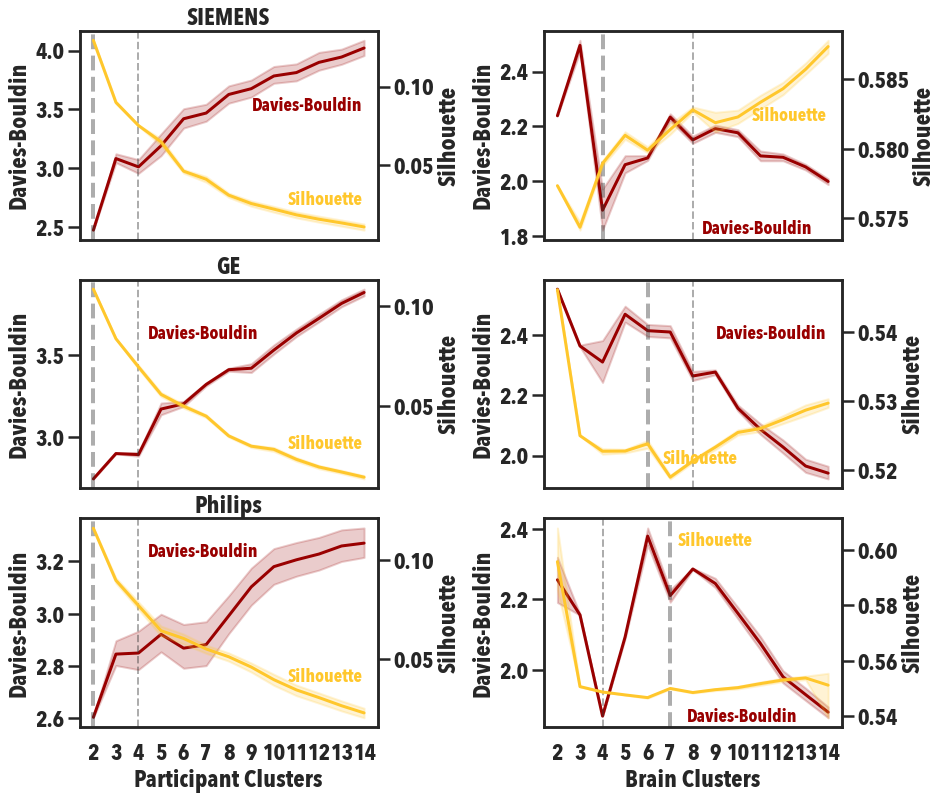

In [9]:
fig,ax = plt.subplots(
    ncols=2, 
    nrows=3, 
    figsize=(13,11), 
    layout='constrained',
    sharex=True
)
# Siemens
# participants
g = sns.lineplot(
    x='ppt_clusters', 
    y='row_davies_bouldin', 
    data=siemens_df, 
    ax=ax[0,0], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax3 = plt.twinx(ax[0,0])
h = sns.lineplot(
    x='ppt_clusters', 
    y='row_silhouette', 
    data=siemens_df, 
    ax=ax3, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[0,0].set_xlabel('Participant Clusters')
ax[0,0].set_title('SIEMENS')
ax[1,0].set_title('GE')
ax[0,0].set_xticks(list(range(2,20)))


# brain
g = sns.lineplot(
    x='mri_clusters', 
    y='col_davies_bouldin', 
    data=siemens_df, 
    ax=ax[0,1], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax4 = plt.twinx(ax[0,1])
h = sns.lineplot(
    x='mri_clusters', 
    y='col_silhouette', 
    data=siemens_df, 
    ax=ax4, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[0,1].set_xlabel('Brain Clusters')




# GE
# brain
g = sns.lineplot(
    x='mri_clusters', 
    y='col_davies_bouldin', 
    data=ge_df, 
    ax=ax[1,1], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax5 = plt.twinx(ax[1,1])
h = sns.lineplot(
    x='mri_clusters', 
    y='col_silhouette', 
    data=ge_df, 
    ax=ax5, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[1,1].set_xlabel('Brain Clusters')


# participants
g = sns.lineplot(
    x='ppt_clusters', 
    y='row_davies_bouldin', 
    data=ge_df, 
    ax=ax[1,0], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax6 = plt.twinx(ax[1,0])
h = sns.lineplot(
    x='ppt_clusters', 
    y='row_silhouette', 
    data=ge_df, 
    ax=ax6, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[1,0].set_xlabel('Participant Clusters')

# philips
# participants
g = sns.lineplot(
    x='ppt_clusters', 
    y='row_davies_bouldin', 
    data=philips_df, 
    ax=ax[2,0], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax3 = plt.twinx(ax[2,0])
h = sns.lineplot(
    x='ppt_clusters', 
    y='row_silhouette', 
    data=philips_df, 
    ax=ax3, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[2,0].set_xlabel('Participant Clusters')
ax[2,0].set_title('Philips')
ax[2,0].set_xticks(list(range(2,20)))


# brain
g = sns.lineplot(
    x='mri_clusters', 
    y='col_davies_bouldin', 
    data=philips_df, 
    ax=ax[2,1], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax4 = plt.twinx(ax[2,1])
h = sns.lineplot(
    x='mri_clusters', 
    y='col_silhouette', 
    data=philips_df, 
    ax=ax4, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[2,1].set_xlabel('Brain Clusters')



ax[0,0].text(0.95, 0.6, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0,0].transAxes,
        color='#990000', fontsize=18)
ax[0,0].text(0.95, 0.15, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0,0].transAxes,
        color='#FFC72C', fontsize=18)

ax[0,1].text(0.9, 0.01, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0,1].transAxes,
        color='#990000', fontsize=18)
ax[0,1].text(0.95, 0.55, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0,1].transAxes,
        color='#FFC72C', fontsize=18)

ax[1,0].text(0.6, 0.7, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1,0].transAxes,
        color='#990000', fontsize=18)
ax[1,0].text(0.95, 0.17, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1,0].transAxes,
        color='#FFC72C', fontsize=18)

ax[1,1].text(0.95, 0.7, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1,1].transAxes,
        color='#990000', fontsize=18)
ax[1,1].text(0.65, 0.1, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1,1].transAxes,
        color='#FFC72C', fontsize=18)

ax[2,0].text(0.6, 0.8, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2,0].transAxes,
        color='#990000', fontsize=18)
ax[2,0].text(0.95, 0.2, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2,0].transAxes,
        color='#FFC72C', fontsize=18)

ax[2,1].text(0.85, 0.01, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2,1].transAxes,
        color='#990000', fontsize=18)
ax[2,1].text(0.7, 0.85, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2,1].transAxes,
        color='#FFC72C', fontsize=18)

ax[0,1].axvline(4, lw=4, ls='--', color='#333333', alpha=0.4)
ax[0,1].axvline(8, lw=2, ls='--', color='#333333', alpha=0.4)
#ax[0,1].axvline(6, lw=2, ls='--', color='#333333', alpha=0.4)

ax[0,0].axvline(4, lw=2, ls='--', color='#333333', alpha=0.4)
#ax[0,0].axvline(6, lw=2, ls='--', color='#333333', alpha=0.4)
ax[0,0].axvline(2, lw=4, ls='--', color='#333333', alpha=0.4)
#ax[0,0].axvline(3, lw=2, ls='--', color='#333333', alpha=0.4)

ax[1,1].axvline(8, lw=2, ls='--', color='#333333', alpha=0.4)
ax[1,1].axvline(6, lw=4, ls='--', color='#333333', alpha=0.4)
#ax[1,1].axvline(8, lw=2, ls='--', color='#333333', alpha=0.4)

ax[1,0].axvline(2, lw=4, ls='--', color='#333333', alpha=0.4)
ax[1,0].axvline(4, lw=2, ls='--', color='#333333', alpha=0.4)
#ax[1,0].axvline(10, lw=2, ls='--', color='#333333', alpha=0.4)

ax[2,1].axvline(4, lw=2, ls='--', color='#333333', alpha=0.4)
#ax[2,1].axvline(6, lw=2, ls='--', color='#333333', alpha=0.4)
ax[2,1].axvline(7, lw=4, ls='--', color='#333333', alpha=0.4)

ax[2,0].axvline(2, lw=4, ls='--', color='#333333', alpha=0.4)
#ax[2,0].axvline(6, lw=2, ls='--', color='#333333', alpha=0.4)
ax[2,0].axvline(4, lw=2, ls='--', color='#333333', alpha=0.4)

fig.savefig(join(PROJ_DIR, FIGS_DIR, 'sbc-dbs_metrics.png'), bbox_inches='tight', dpi=600)

atlas = 'desikankillany'

siemens_ppt = join(PROJ_DIR, OUTP_DIR, 'sbc-dbs_desikankillany-SIEMENS_ppt-labels-2023-07-09.csv')
ge_ppt = join(PROJ_DIR, OUTP_DIR, 'sbc-dbs_desikankillany-GE MEDICAL SYSTEMS_ppt-labels-2023-07-09.csv')

siemens_mri = f'{PROJ_DIR}{OUTP_DIR}sbc-dbs_desikankillany-SIEMENS_mri-labels-2023-07-09.csv'
ge_mri = f'{PROJ_DIR}{OUTP_DIR}sbc-dbs_desikankillany-GE MEDICAL SYSTEMS_mri-labels-2023-07-09.csv'


siemens_mri_df = pd.read_csv(siemens_mri, index_col=0, header=0)
ge_mri_df = pd.read_csv(ge_mri, index_col=0, header=0)


siemens_ppt_df = pd.read_csv(siemens_ppt, index_col=0, header=0)
ge_ppt_df = pd.read_csv(ge_ppt, index_col=0, header=0)

In [13]:
df = pd.read_pickle(join(PROJ_DIR, DATA_DIR, "data_qcd.pkl"))
#imputed_dcg = pd.read_csv(join(join(PROJ_DIR, DATA_DIR, "destrieux+gordon_MICEimputed_data.csv")), 
#                          index_col='subjectkey', 
#                          header=0)



brain_df = df.filter(regex='.*mri.*change_score')

In [14]:
numerical = ["interview_age",
             "nihtbx_picvocab_uncorrected",
        "nihtbx_flanker_uncorrected",
        #"nihtbx_list_uncorrected",
        #"nihtbx_cardsort_uncorrected",
        "nihtbx_pattern_uncorrected",
        "nihtbx_picture_uncorrected",
        "nihtbx_reading_uncorrected", "pds_p_ss_female_category_2", 
        "pds_p_ss_male_category_2","cbcl_scr_syn_anxdep_r", 
        "cbcl_scr_syn_withdep_r", 
        "cbcl_scr_syn_somatic_r", 
        "cbcl_scr_syn_social_r", 
        "cbcl_scr_syn_thought_r", 
        "cbcl_scr_syn_attention_r", 
        "cbcl_scr_syn_rulebreak_r", 
        "cbcl_scr_syn_aggressive_r", 
        "cbcl_scr_syn_internal_r", 
        "cbcl_scr_syn_external_r", 
        "cbcl_scr_syn_totprob_r", ]

non_numerical = [#"interview_date", 
        "sex", "site_id_l", "demo_prnt_ethn_v2",
        "demo_prnt_marital_v2",
        "demo_prnt_ed_v2",
        "demo_comb_income_v2"]
vars_of_interest = numerical + non_numerical

In [15]:
seven = sns.crayon_palette(
    [
        'Silver','Silver','Silver','Silver','Silver','Silver','Silver','Silver','Silver','Silver','Silver','Silver','Silver','Silver',
        'Fuchsia',
        "Purple Heart",
        'Denim',
        'Blue',
        'Cerulean',
        'Caribbean Green',
        'Electric Lime',
        #'Goldenrod',
        'Sunglow',
        'Yellow Orange',
        'Orange',
        'Red Orange', 
        'Radical Red',
        'Razzmatazz',
        'Hot Magenta',
        'Silver'
    ],
    
)

seven_cmap = sns.color_palette(seven.as_hex(), desat=0.8, as_cmap=True)
negative_vals = sns.color_palette(seven.as_hex()[:7])
negative_cmap = sns.blend_palette(negative_vals, as_cmap=True)

positive_vals = sns.color_palette(seven.as_hex()[7:])
positive_cmap = sns.blend_palette(positive_vals, as_cmap=True)


both_cmap = sns.blend_palette(seven_cmap, as_cmap=True)
#seven = sns.husl_palette(n_colors=14)


In [16]:
scanners = ["SIEMENS", "GE MEDICAL SYSTEMS", "Philips Medical Systems"]
measures = ['smri_thick', 'dmri_rsirnigm', 'dmri_rsirndgm', 'rsfmri_var']
imaging_cols = list(df.filter(regex='.*mri.*change_score').columns)

noisy_modalities = {
    'smri': [
        "smri_vol_cdk_total"
        ],
    'dmri': [
        'dmri_rsi_meanmotion',
        'dmri_rsi_meantrans',
        'dmri_rsi_meanrot'
        ], 
    'rsfmri': [
        'rsfmri_var_ntpoints', 
        'rsfmri_var_meanmotion',
        'rsfmri_var_meantrans',
        'rsfmri_var_maxtrans',
        'rsfmri_var_meanrot',
        'rsfmri_var_maxrot'
        ]
}

timepoints = [
    'baseline_year_1_arm_1',
    '2_year_follow_up_y_arm_1',
    'change_score'
]

imaging = df.filter(regex='.*mri.*change_score')
for cov in [item for sublist in noisy_modalities.values() for item in sublist]:
    #print(cov)
    for tp in timepoints:
        if f'{cov}.{tp}' in imaging.columns:
            imaging = imaging.drop(f'{cov}.{tp}', axis=1)
imaging_cols = list(imaging.columns)
#imaging_cols.append('rel_family_id.baseline_year_1_arm_1')



In [17]:
estimator = SpectralBiclustering(

    method='bistochastic',
    n_clusters=(2, 8),
    random_state=1
)
siemens_data = df[df['mri_info_manufacturer.baseline_year_1_arm_1'] == "SIEMENS"][imaging_cols].dropna()
siemens_cols = siemens_data.columns
siemens_rows = siemens_data.index

resid_temp = pd.DataFrame()
for modality in noisy_modalities.keys():
    cov_df = pd.DataFrame()
    mini_dset = siemens_data.filter(regex=f'{modality}.*', axis=1)
    subj = siemens_data.index
    img_cols = mini_dset.columns
    covs = []
    for covariate in noisy_modalities[modality]:
        smol = df.loc[subj]
        covs.append(f'{covariate}.baseline_year_1_arm_1')
        covs.append(f'{covariate}.2_year_follow_up_y_arm_1')
        cov_df = pd.concat([cov_df, smol[f'{covariate}.baseline_year_1_arm_1']], axis=1)
        cov_df = pd.concat([cov_df, smol[f'{covariate}.2_year_follow_up_y_arm_1']], axis=1)
    #print(img_cols, covs)
    mini_dset = pd.concat([mini_dset, cov_df], axis=1)
    #print(mini_dset.describe())
    #print('residualizing', img_cols, 'with', covs)
    temp2 = residualize(mini_dset[img_cols], confounds=mini_dset[covs])
    resid_temp = pd.concat([resid_temp, temp2], axis=1)
siemens_data = pd.DataFrame(
    Normalizer().fit_transform(resid_temp), 
    index=resid_temp.index, 
    columns=resid_temp.columns)

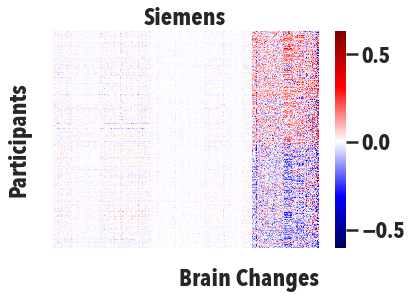

In [18]:

siemens_model = estimator.fit(siemens_data)

row_order = pd.Series(siemens_model.row_labels_, index=siemens_data.index)
column_order = pd.Series(siemens_model.column_labels_, index=siemens_data.columns)
row_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'siemens-ppt_clusters.pkl'))
column_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'siemens-mri_clusters.pkl'))

reordered_rows = siemens_data.loc[row_order.sort_values().index]
reordered_data = reordered_rows[column_order.sort_values().index]
reordered_data.to_csv(join(PROJ_DIR, OUTP_DIR, 'siemens-biclusters.csv'))

fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(reordered_data, cmap='seismic', ax=ax, center=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylabel('Participants')
ax.set_xlabel('Brain Changes', loc='right')
ax.set_title('Siemens')
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'biclustering_grid-siemens.png'), bbox_inches='tight', dpi=600)

In [19]:
column_order[column_order == 5]

rsfmri_var_cdk_banksstslh.change_score       5
rsfmri_var_cdk_paracentrallh.change_score    5
rsfmri_var_cdk_postcentrallh.change_score    5
rsfmri_var_cdk_precentrallh.change_score     5
rsfmri_var_cdk_sutlh.change_score            5
rsfmri_var_cdk_tvtlh.change_score            5
rsfmri_var_cdk_banksstsrh.change_score       5
rsfmri_var_cdk_paracentralrh.change_score    5
rsfmri_var_cdk_postcentralrh.change_score    5
rsfmri_var_cdk_precentralrh.change_score     5
rsfmri_var_cdk_sutrh.change_score            5
rsfmri_var_cdk_tvtrh.change_score            5
dtype: int32

cortex


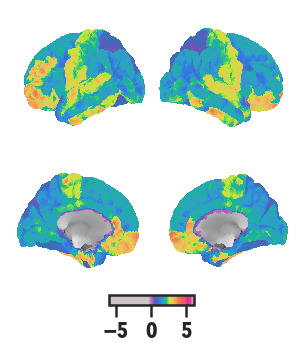

In [20]:
vmax = np.max(column_order) - 1

one_indexed = column_order + 1

for measure in measures[3:]:
    cols = one_indexed.filter(like=measure)
    #print(len(cols.index), len(cols[cols != 0].index))
    if len(cols.index) == 0:
        pass
    else:
        cols.name = f'siemens-{measure}'
        nifti = series_2_nifti(cols, '../output', save=True)
        plotting.plot_img_on_surf(
            nifti,
            cmap=both_cmap, 
            threshold=0.00001,
            vmax=vmax,
            symmetric_cbar=False,
            kwargs={'bg_on_data':True, 'alpha': 0.5, 'avg_method': 'max'},
            #output_file=f'../figures/{cols.name}.png'
        )

In [21]:

estimator = SpectralBiclustering(

    method='bistochastic',
    n_clusters=(2, 6),
    random_state=1
)
ge_data = df[df['mri_info_manufacturer.baseline_year_1_arm_1'] == "GE MEDICAL SYSTEMS"][imaging_cols].dropna()
ge_cols = ge_data.columns
ge_rows = ge_data.index


resid_temp = pd.DataFrame()
for modality in noisy_modalities.keys():
    cov_df = pd.DataFrame()
    mini_dset = ge_data.filter(regex=f'{modality}.*', axis=1)
    subj = ge_data.index
    img_cols = mini_dset.columns
    covs = []
    for covariate in noisy_modalities[modality]:
        smol = df.loc[subj]
        covs.append(f'{covariate}.baseline_year_1_arm_1')
        covs.append(f'{covariate}.2_year_follow_up_y_arm_1')
        cov_df = pd.concat([cov_df, smol[f'{covariate}.baseline_year_1_arm_1']], axis=1)
        cov_df = pd.concat([cov_df, smol[f'{covariate}.2_year_follow_up_y_arm_1']], axis=1)
    #print(img_cols, covs)
    mini_dset = pd.concat([mini_dset, cov_df], axis=1)
    #print(mini_dset.describe())
    #print('residualizing', img_cols, 'with', covs)
    temp2 = residualize(mini_dset[img_cols], confounds=mini_dset[covs])
    resid_temp = pd.concat([resid_temp, temp2], axis=1)
ge_data = pd.DataFrame(
    Normalizer().fit_transform(resid_temp), 
    index=resid_temp.index, 
    columns=resid_temp.columns)

#ge_model = estimator.fit(ge_data)
#philips_model = estimator.fit(philips_data)

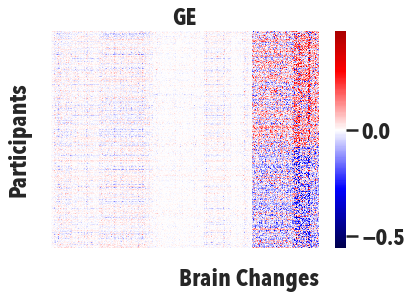

In [22]:
ge_model = estimator.fit(ge_data)

row_order = pd.Series(ge_model.row_labels_, index=ge_data.index)
column_order = pd.Series(ge_model.column_labels_, index=ge_data.columns)
row_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'ge-ppt_clusters.pkl'))
column_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'ge-mri_clusters.pkl'))

reordered_rows = ge_data.loc[row_order.sort_values().index]
reordered_data = reordered_rows[column_order.sort_values().index]
reordered_data.to_csv(join(PROJ_DIR, OUTP_DIR, 'ge-biclusters.csv'))

fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(reordered_data, cmap='seismic', ax=ax, center=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylabel('Participants')
ax.set_xlabel('Brain Changes', loc='right')
ax.set_title('GE')
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'biclustering_grid-ge.png'), bbox_inches='tight', dpi=600)

In [23]:
column_order[column_order == 5]

rsfmri_var_cdk_fflh.change_score          5
rsfmri_var_cdk_mdtlh.change_score         5
rsfmri_var_cdk_parahpallh.change_score    5
rsfmri_var_cdk_rlaclatelh.change_score    5
rsfmri_var_cdk_insulalh.change_score      5
rsfmri_var_cdk_ffrh.change_score          5
rsfmri_var_cdk_mdtrh.change_score         5
rsfmri_var_cdk_parahpalrh.change_score    5
rsfmri_var_cdk_rlaclaterh.change_score    5
dtype: int32

cortex


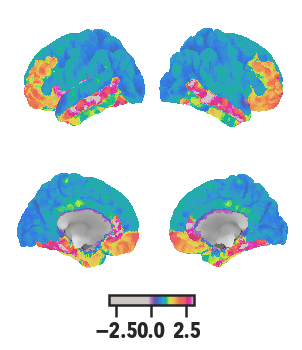

In [24]:
vmax = np.max(column_order) - 1

one_indexed = column_order + 1

for measure in measures[3:]:
    cols = one_indexed.filter(like=measure)

    #print(len(cols.index), len(cols[cols != 0].index))
    if len(cols.index) == 0:
        pass
    else:
        cols.name = f'ge-{measure}'
        nifti = series_2_nifti(cols, '../output', save=True)
        plotting.plot_img_on_surf(
            nifti,
            cmap=both_cmap, 
            threshold=0.00001,
            vmax=3,
            symmetric_cbar=False,
            kwargs={'bg_on_data':True, 'alpha': 0.5, 'avg_method': 'max'},
            #output_file=f'../figures/{cols.name}.png'
        )

In [25]:

estimator = SpectralBiclustering(

    method='bistochastic',
    n_clusters=(2, 7),
    random_state=1
)
philips_data = df[df['mri_info_manufacturer.baseline_year_1_arm_1'] == "Philips Medical Systems"][imaging_cols].dropna()
philips_cols = philips_data.columns
philips_rows = philips_data.index


resid_temp = pd.DataFrame()
for modality in noisy_modalities.keys():
    cov_df = pd.DataFrame()
    mini_dset = philips_data.filter(regex=f'{modality}.*', axis=1)
    subj = philips_data.index
    img_cols = mini_dset.columns
    covs = []
    for covariate in noisy_modalities[modality]:
        smol = df.loc[subj]
        covs.append(f'{covariate}.baseline_year_1_arm_1')
        covs.append(f'{covariate}.2_year_follow_up_y_arm_1')
        cov_df = pd.concat([cov_df, smol[f'{covariate}.baseline_year_1_arm_1']], axis=1)
        cov_df = pd.concat([cov_df, smol[f'{covariate}.2_year_follow_up_y_arm_1']], axis=1)
    #print(img_cols, covs)
    mini_dset = pd.concat([mini_dset, cov_df], axis=1)
    #print(mini_dset.describe())
    #print('residualizing', img_cols, 'with', covs)
    temp2 = residualize(mini_dset[img_cols], confounds=mini_dset[covs])
    resid_temp = pd.concat([resid_temp, temp2], axis=1)
philips_data = pd.DataFrame(
    Normalizer().fit_transform(resid_temp), 
    index=resid_temp.index, 
    columns=resid_temp.columns)

#philips_model = estimator.fit(philips_data)
#philips_model = estimator.fit(philips_data)

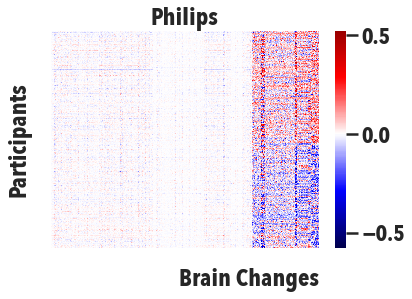

In [26]:
philips_model = estimator.fit(philips_data)

row_order = pd.Series(philips_model.row_labels_, index=philips_data.index)
column_order = pd.Series(philips_model.column_labels_, index=philips_data.columns)
row_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'philips-ppt_clusters.pkl'))
column_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'philips-mri_clusters.pkl'))

reordered_rows = philips_data.loc[row_order.sort_values().index]
reordered_data = reordered_rows[column_order.sort_values().index]
reordered_data.to_csv(join(PROJ_DIR, OUTP_DIR, 'philips-biclusters.csv'))

fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(reordered_data, cmap='seismic', ax=ax, center=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylabel('Participants')
ax.set_xlabel('Brain Changes', loc='right')
ax.set_title('Philips')
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'biclustering_grid-philips.png'), bbox_inches='tight', dpi=600)

In [27]:
column_order[column_order == 0]

smri_thick_cdk_banksstslh.change_score    0
smri_thick_cdk_cdacatelh.change_score     0
smri_thick_cdk_cdmdfrlh.change_score      0
smri_thick_cdk_cuneuslh.change_score      0
smri_thick_cdk_ehinallh.change_score      0
                                         ..
dmri_rsirndgm_cdk_smrh.change_score       0
dmri_rsirndgm_cdk_fprh.change_score       0
dmri_rsirndgm_cdk_tprh.change_score       0
dmri_rsirndgm_cdk_ttrh.change_score       0
dmri_rsirndgm_cdk_isrh.change_score       0
Length: 204, dtype: int32

cortex


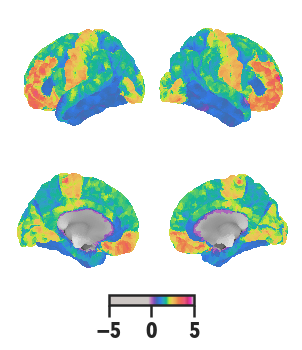

In [28]:
vmax = np.max(column_order) - 1


one_indexed = column_order + 1

for measure in measures[3:]:
    cols = one_indexed.filter(like=measure)

    #print(len(cols.index), len(cols[cols != 0].index))
    if len(cols.index) == 0:
        pass
    else:
        cols.name = f'philips-{measure}'
        nifti = series_2_nifti(cols, '../output', save=True)
        plotting.plot_img_on_surf(
            nifti,
            cmap=both_cmap, 
            threshold=0.00001,
            vmax=vmax,
            symmetric_cbar=False,
            kwargs={'bg_on_data':True, 'alpha': 0.5, 'avg_method': 'max'},
            #output_file=f'../figures/{cols.name}.png'
        )

In [29]:

cols = []
for var in numerical:
    columns = df.filter(regex=f'{var}.*', axis=1).columns
    if len(columns) == 0:
        pass
    else:
        for column in columns:
            cols.append(column)
alpha, _= jili_sidak_mc(df[cols], 0.05)

scanners = ['siemens', 'ge', 'philips']
#models = ['', '-nofmri']
stats = ['r', 'p']
groups = [0,1]

clusters = [
    'siemens-0', 'siemens-1', 
    'ge-0', 'ge-1',
    'philips-0', 'philips-1',
]
#index = pd.MultiIndex.from_product([stats, clusters])

outcomes_by_cluster = pd.DataFrame(
    columns=clusters, 
    index=cols,
    dtype=float
)

pvals_by_cluster = pd.DataFrame(
    columns=clusters, 
    index=cols,
    dtype=float
)

sigs = pd.DataFrame(
    columns=clusters, 
    index=cols,
    dtype=str
)
for scanner in scanners:
    #for model in models:
    ppt_clusters = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, f'{scanner}-ppt_clusters.pkl'))
    temp = df.loc[ppt_clusters.index]
    dummy_clusters = pd.get_dummies(ppt_clusters)
    for cluster in dummy_clusters.columns:
        for col in cols:
            temp2 = pd.concat([dummy_clusters[cluster], temp[col]], axis=1).dropna()
            if len(temp2[col].index) < 2:
                pass
            else:
                r, p = pointbiserialr(temp2[cluster], temp2[col])
                outcomes_by_cluster.at[col, f'{scanner}-{cluster}'] = r
                pvals_by_cluster.at[col, f'{scanner}-{cluster}'] = p
                if p < alpha:
                    sigs.at[col, f'{scanner}-{cluster}'] = '*'
                else:
                    sigs.at[col, f'{scanner}-{cluster}'] = ''


For 43 vars, number of effective comparisons: 21.76508867624266

Critical value of 0.050 becomes 0.002354 after corrections


In [30]:
for i in outcomes_by_cluster.index:
    outcomes_by_cluster.at[i, 'instrument'] = i.split('_')[0]

In [31]:
sigs

,siemens-0,siemens-1,ge-0,ge-1,philips-0,philips-1
interview_age.2_year_follow_up_y_arm_1,,,,,,
interview_age.baseline_year_1_arm_1,,,,,,
nihtbx_picvocab_uncorrected.baseline_year_1_arm_1,,,*,*,,
nihtbx_picvocab_uncorrected.change_score,,,,,,
nihtbx_picvocab_uncorrected.2_year_follow_up_y_arm_1,,,*,*,,
nihtbx_flanker_uncorrected.baseline_year_1_arm_1,,,*,*,,
nihtbx_flanker_uncorrected.change_score,,,,,,
nihtbx_flanker_uncorrected.2_year_follow_up_y_arm_1,,,,,,
nihtbx_pattern_uncorrected.2_year_follow_up_y_arm_1,,,,,,
nihtbx_pattern_uncorrected.baseline_year_1_arm_1,,,,,*,*


In [32]:
sns.set_context('talk')


nine_ten = outcomes_by_cluster.filter(like='baseline_year_1_arm_1', axis=0).sort_values('ge-0', ascending=False).index
eleven_twelve = outcomes_by_cluster.filter(like='2_year_follow_up_y_arm_1', axis=0).sort_values('ge-0', ascending=False).index
change = outcomes_by_cluster.filter(like='change_score', axis=0).sort_values('ge-0', ascending=False).index

row_order = list(nine_ten) + list(eleven_twelve) + list(change)


In [33]:
outcomes_by_cluster.loc[row_order][clusters]

,siemens-0,siemens-1,ge-0,ge-1,philips-0,philips-1
pds_p_ss_male_category_2.baseline_year_1_arm_1,0.039190,-0.039190,0.113781,-0.113781,0.075077,-0.075077
cbcl_scr_syn_social_r.baseline_year_1_arm_1,0.023427,-0.023427,0.038548,-0.038548,-0.099689,0.099689
cbcl_scr_syn_rulebreak_r.baseline_year_1_arm_1,0.012776,-0.012776,0.031125,-0.031125,-0.076324,0.076324
cbcl_scr_syn_thought_r.baseline_year_1_arm_1,0.008355,-0.008355,0.024530,-0.024530,-0.090564,0.090564
cbcl_scr_syn_attention_r.baseline_year_1_arm_1,0.025710,-0.025710,0.014096,-0.014096,-0.047097,0.047097
pds_p_ss_female_category_2.baseline_year_1_arm_1,0.023976,-0.023976,0.009682,-0.009682,-0.076176,0.076176
cbcl_scr_syn_external_r.baseline_year_1_arm_1,0.014522,-0.014522,0.009288,-0.009288,-0.059421,0.059421
cbcl_scr_syn_totprob_r.baseline_year_1_arm_1,0.014772,-0.014772,0.006009,-0.006009,-0.088180,0.088180
cbcl_scr_syn_somatic_r.baseline_year_1_arm_1,-0.005022,0.005022,-0.000504,0.000504,-0.028710,0.028710
cbcl_scr_syn_aggressive_r.baseline_year_1_arm_1,0.014032,-0.014032,-0.001103,0.001103,-0.046577,0.046577


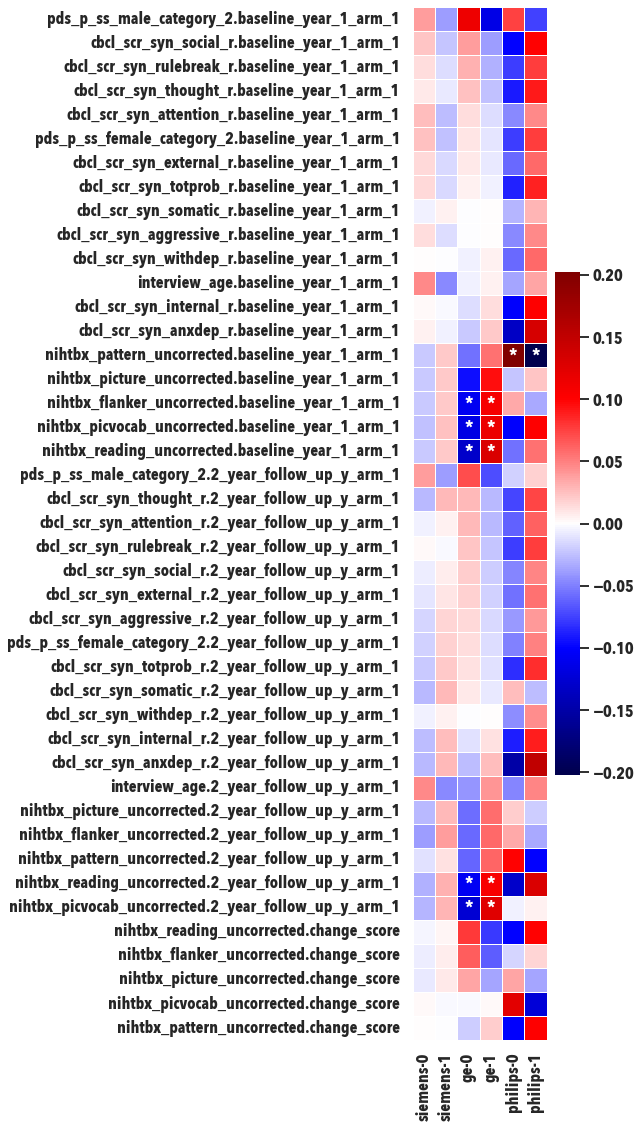

In [34]:
sns.set_context('talk')


nine_ten = outcomes_by_cluster.filter(like='baseline_year_1_arm_1', axis=0).sort_values('ge-0', ascending=False).index
eleven_twelve = outcomes_by_cluster.filter(like='2_year_follow_up_y_arm_1', axis=0).sort_values('ge-0', ascending=False).index
change = outcomes_by_cluster.filter(like='change_score', axis=0).sort_values('ge-0', ascending=False).index

row_order = list(nine_ten) + list(eleven_twelve) + list(change)

fig,ax = plt.subplots(figsize=(3,19))
sns.heatmap(
    outcomes_by_cluster.loc[row_order][clusters], 
    cmap='seismic',
    center=0,
    linewidths=1,
    linecolor='w',
    annot=sigs.fillna('').loc[row_order].values,
    fmt=''
)
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'cluster_by_outcome_corrs.png'), bbox_inches='tight', dpi=600)

In [35]:
non_numerical = [#"interview_date", 
        "sex", "site_id_l", "demo_prnt_ethn_v2",
        "demo_prnt_marital_v2",
        "demo_prnt_ed_v2",
        "demo_comb_income_v2"]

cols = []
for var in non_numerical:
    columns = df.filter(regex=f'{var}.*', axis=1).columns
    if len(columns) == 0:
        pass
    else:
        for column in columns:
            cols.append(column)

#print(len(cols))
#print(cols)
non_df = df[cols]

cat_alpha,_ = jili_sidak_mc(non_df, 0.05)


For 8 vars, number of effective comparisons: 3.867795957076392

Critical value of 0.050 becomes 0.013174 after corrections


/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_9739/942206915.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mc_corrmat = data.corr()


In [36]:
non_numerical = [#"interview_date", 
        "sex", "site_id_l", "demo_prnt_ethn_v2",
        "demo_prnt_marital_v2",
        "demo_prnt_ed_v2",
        "demo_comb_income_v2"]

cols = []
for var in non_numerical:
    columns = df.filter(regex=f'{var}.*', axis=1).columns
    if len(columns) == 0:
        pass
    else:
        for column in columns:
            cols.append(column)

#print(len(cols))
#print(cols)
non_df = df[cols]

cat_alpha,_ = jili_sidak_mc(non_df, 0.05)

stats = ['x2', 'p']
cols = pd.MultiIndex.from_product([scanners, stats])

table = pd.DataFrame(columns=clusters, dtype=float)
props = pd.DataFrame(columns=clusters, dtype=float)
chisq = pd.DataFrame(columns=cols, index=non_df.columns, dtype=float)
sigs = pd.DataFrame(dtype=str)
#print(dat.columns)
for scanner in scanners:
    ppt_clusters = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, f'{scanner}-ppt_clusters.pkl'))
    temp = df.loc[ppt_clusters.index]
    for non in non_df.columns:
        dummies = pd.get_dummies(non_df[non])
        #print(dummies.columns)
        small_table = pd.DataFrame(columns=dummies.columns, index=clusters)
        for dumb in dummies.columns:
            if dumb not in [777., 999.]:
                vals = dummies[dumb]
                if vals[temp.index].sum() == 0:
                    pass
                else:
                    dummy_clusters = pd.get_dummies(ppt_clusters)
                    for cluster in dummy_clusters.columns:
                        ppts1 = dummy_clusters[dummy_clusters[cluster] > .1].index
                        one_vals = vals.loc[ppts1]

                        table.at[f'{non}_{dumb}', f'{scanner}-{cluster}'] = one_vals.sum()
                        props.at[f'{non}_{dumb}', f'{scanner}-{cluster}'] = one_vals.sum() / len(ppts1)
                        small_table.at[f'{scanner}-{cluster}', dumb] = one_vals.sum()
        #print(small_table)
        if small_table.sum().sum() > 0:
            x2,p,_,_ = chi2_contingency(small_table.dropna(how='all', axis=1).dropna(how='all', axis=0))
            #print(non, x2, p)
            chisq.at[non, (scanner, 'x2')] = x2
            chisq.at[non, (scanner, 'p')] = p
            if p < cat_alpha:
                sigs.at[non, scanner] = '*'
            else:
                sigs.at[non, scanner] = ''
        else:
            pass
        # do a chi-square test for differences across clusters for each variable.
    #table.dropna(how='all', axis=1).to_csv(join(PROJ_DIR, 'output', f'categorical_vals_by_cluster_{scanner}.csv'))
    #chisq.dropna(how='all', axis=1).to_csv(join(PROJ_DIR, 'output', f'non_numerical_differences_by_cluster_{scanner}.csv'))
chisq.dropna(how='all', inplace=True)
sigs.dropna(how='all', inplace=True)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_9739/942206915.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mc_corrmat = data.corr()



For 8 vars, number of effective comparisons: 3.867795957076392

Critical value of 0.050 becomes 0.013174 after corrections


In [37]:
chisq.swaplevel(axis=1)['x2']

,siemens,ge,philips
sex.baseline_year_1_arm_1,0.012661,0.254622,0.084404
sex.2_year_follow_up_y_arm_1,0.012661,0.254622,0.084404
site_id_l.2_year_follow_up_y_arm_1,42.559135,63.732322,10.943421
site_id_l.baseline_year_1_arm_1,41.211775,58.020921,8.339781
demo_prnt_ethn_v2.baseline_year_1_arm_1,1.465557,1.714088,0.219866
demo_prnt_marital_v2.baseline_year_1_arm_1,22.435965,16.190686,8.734879
demo_prnt_ed_v2.baseline_year_1_arm_1,23.128288,28.190075,11.898330
demo_comb_income_v2.baseline_year_1_arm_1,28.574568,17.701622,11.080874


In [38]:
sigs

,siemens,ge,philips
sex.baseline_year_1_arm_1,,,
sex.2_year_follow_up_y_arm_1,,,
site_id_l.2_year_follow_up_y_arm_1,*,*,
site_id_l.baseline_year_1_arm_1,*,*,
demo_prnt_ethn_v2.baseline_year_1_arm_1,,,
demo_prnt_marital_v2.baseline_year_1_arm_1,*,*,
demo_prnt_ed_v2.baseline_year_1_arm_1,,,
demo_comb_income_v2.baseline_year_1_arm_1,*,,


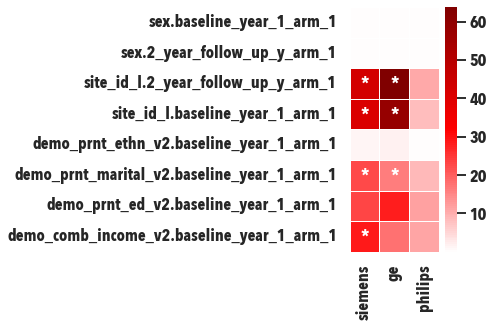

In [40]:
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(2,4.5))
sns.heatmap(
    chisq.swaplevel(axis=1)['x2'], 
    cmap='seismic',
    center=0,
    linewidths=1,
    linecolor='w',
    annot=sigs,
    fmt=''
)
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'all_meas_cat_by_cluster_chisq.png'), bbox_inches='tight', dpi=600)

In [41]:
siemens = f'{PROJ_DIR}{OUTP_DIR}sbc-dbs_desikankillany-SIEMENS_best-models-2023-07-12-nofmri.csv'
ge = f'{PROJ_DIR}{OUTP_DIR}sbc-dbs_desikankillany-GE MEDICAL SYSTEMS_best-models-2023-07-12-nofmri.csv'
philips = f'{PROJ_DIR}{OUTP_DIR}sbc-dbs_desikankillany-Philips Medical Systems_best-models-2023-07-12-nofmri.csv'
measures = ['smri_thick', 'dmri_rsirnigm', 'dmri_rsirndgm']

siemens_df = pd.read_csv(siemens, index_col=0, header=0)
ge_df = pd.read_csv(ge, index_col=0, header=0)
philips_df = pd.read_csv(philips, index_col=0, header=0)


sns.set_context('poster')

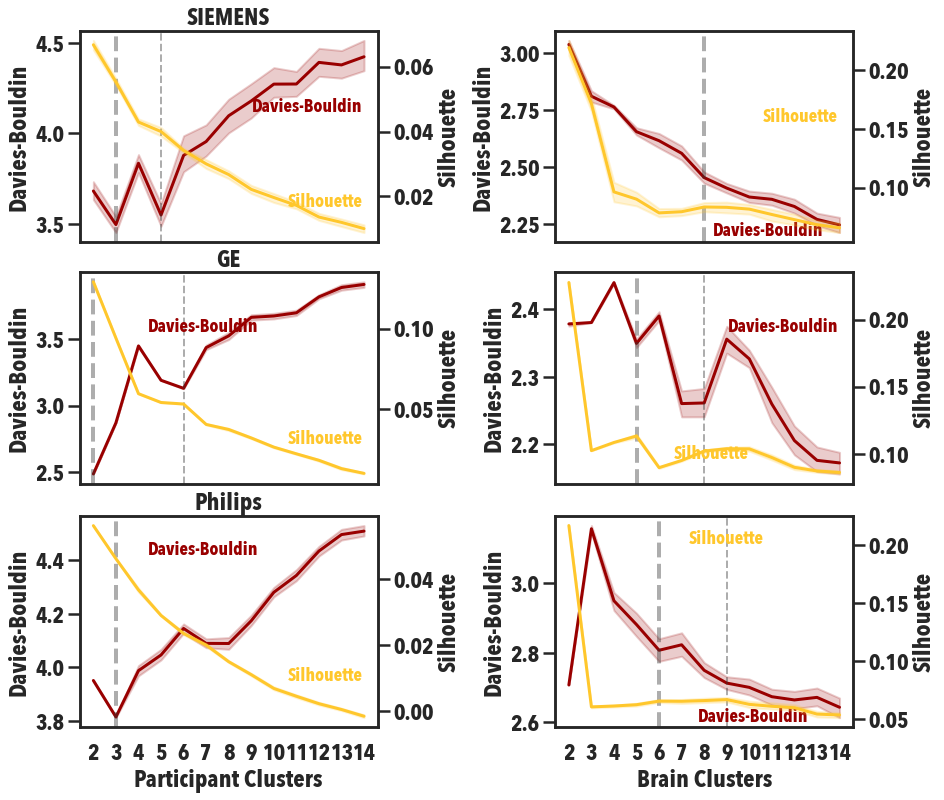

In [42]:
fig,ax = plt.subplots(
    ncols=2, 
    nrows=3, 
    figsize=(13,11), 
    layout='constrained',
    sharex=True
)
# Siemens
# participants
g = sns.lineplot(
    x='ppt_clusters', 
    y='row_davies_bouldin', 
    data=siemens_df, 
    ax=ax[0,0], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax3 = plt.twinx(ax[0,0])
h = sns.lineplot(
    x='ppt_clusters', 
    y='row_silhouette', 
    data=siemens_df, 
    ax=ax3, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[0,0].set_xlabel('Participant Clusters')
ax[0,0].set_title('SIEMENS')
ax[1,0].set_title('GE')
ax[0,0].set_xticks(list(range(2,20)))


# brain
g = sns.lineplot(
    x='mri_clusters', 
    y='col_davies_bouldin', 
    data=siemens_df, 
    ax=ax[0,1], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax4 = plt.twinx(ax[0,1])
h = sns.lineplot(
    x='mri_clusters', 
    y='col_silhouette', 
    data=siemens_df, 
    ax=ax4, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[0,1].set_xlabel('Brain Clusters')




# GE
# brain
g = sns.lineplot(
    x='mri_clusters', 
    y='col_davies_bouldin', 
    data=ge_df, 
    ax=ax[1,1], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax5 = plt.twinx(ax[1,1])
h = sns.lineplot(
    x='mri_clusters', 
    y='col_silhouette', 
    data=ge_df, 
    ax=ax5, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[1,1].set_xlabel('Brain Clusters')


# participants
g = sns.lineplot(
    x='ppt_clusters', 
    y='row_davies_bouldin', 
    data=ge_df, 
    ax=ax[1,0], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax6 = plt.twinx(ax[1,0])
h = sns.lineplot(
    x='ppt_clusters', 
    y='row_silhouette', 
    data=ge_df, 
    ax=ax6, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[1,0].set_xlabel('Participant Clusters')

# philips
# participants
g = sns.lineplot(
    x='ppt_clusters', 
    y='row_davies_bouldin', 
    data=philips_df, 
    ax=ax[2,0], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax3 = plt.twinx(ax[2,0])
h = sns.lineplot(
    x='ppt_clusters', 
    y='row_silhouette', 
    data=philips_df, 
    ax=ax3, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[2,0].set_xlabel('Participant Clusters')
ax[2,0].set_title('Philips')
ax[2,0].set_xticks(list(range(2,20)))


# brain
g = sns.lineplot(
    x='mri_clusters', 
    y='col_davies_bouldin', 
    data=philips_df, 
    ax=ax[2,1], 
    color='#990000',
    errorbar=('ci', 99)
    
)

ax4 = plt.twinx(ax[2,1])
h = sns.lineplot(
    x='mri_clusters', 
    y='col_silhouette', 
    data=philips_df, 
    ax=ax4, 
    color='#FFC72C',
    errorbar=('ci', 99)
)

g.set_ylabel('Davies-Bouldin')
h.set_ylabel('Silhouette')
ax[2,1].set_xlabel('Brain Clusters')



ax[0,0].text(0.95, 0.6, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0,0].transAxes,
        color='#990000', fontsize=18)
ax[0,0].text(0.95, 0.15, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0,0].transAxes,
        color='#FFC72C', fontsize=18)

ax[0,1].text(0.9, 0.01, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0,1].transAxes,
        color='#990000', fontsize=18)
ax[0,1].text(0.95, 0.55, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0,1].transAxes,
        color='#FFC72C', fontsize=18)

ax[1,0].text(0.6, 0.7, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1,0].transAxes,
        color='#990000', fontsize=18)
ax[1,0].text(0.95, 0.17, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1,0].transAxes,
        color='#FFC72C', fontsize=18)

ax[1,1].text(0.95, 0.7, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1,1].transAxes,
        color='#990000', fontsize=18)
ax[1,1].text(0.65, 0.1, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1,1].transAxes,
        color='#FFC72C', fontsize=18)

ax[2,0].text(0.6, 0.8, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2,0].transAxes,
        color='#990000', fontsize=18)
ax[2,0].text(0.95, 0.2, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2,0].transAxes,
        color='#FFC72C', fontsize=18)

ax[2,1].text(0.85, 0.01, 'Davies-Bouldin',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2,1].transAxes,
        color='#990000', fontsize=18)
ax[2,1].text(0.7, 0.85, 'Silhouette',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2,1].transAxes,
        color='#FFC72C', fontsize=18)

ax[0,1].axvline(8, lw=4, ls='--', color='#333333', alpha=0.4)
#ax[0,1].axvline(8, lw=2, ls='--', color='#333333', alpha=0.4)
#ax[0,1].axvline(6, lw=2, ls='--', color='#333333', alpha=0.4)

ax[0,0].axvline(5, lw=2, ls='--', color='#333333', alpha=0.4)
#ax[0,0].axvline(6, lw=2, ls='--', color='#333333', alpha=0.4)
ax[0,0].axvline(3, lw=4, ls='--', color='#333333', alpha=0.4)
#ax[0,0].axvline(3, lw=2, ls='--', color='#333333', alpha=0.4)

#ax[1,1].axvline(3, lw=2, ls='--', color='#333333', alpha=0.4)
ax[1,1].axvline(5, lw=4, ls='--', color='#333333', alpha=0.4)
ax[1,1].axvline(8, lw=2, ls='--', color='#333333', alpha=0.4)

ax[1,0].axvline(2, lw=4, ls='--', color='#333333', alpha=0.4)
ax[1,0].axvline(6, lw=2, ls='--', color='#333333', alpha=0.4)
#ax[1,0].axvline(10, lw=2, ls='--', color='#333333', alpha=0.4)

ax[2,1].axvline(9, lw=2, ls='--', color='#333333', alpha=0.4)
ax[2,1].axvline(6, lw=4, ls='--', color='#333333', alpha=0.4)
#ax[2,1].axvline(7, lw=2, ls='--', color='#333333', alpha=0.4)

ax[2,0].axvline(3, lw=4, ls='--', color='#333333', alpha=0.4)
#ax[2,0].axvline(6, lw=2, ls='--', color='#333333', alpha=0.4)
#ax[2,0].axvline(5, lw=2, ls='--', color='#333333', alpha=0.4)

fig.savefig(join(PROJ_DIR, FIGS_DIR, 'sbc-dbs_metrics-nofmri.png'), bbox_inches='tight', dpi=600)

In [43]:
imaging_cols = list(set(imaging.columns) - set(imaging.filter(like='rsfmri_var', axis=1).columns))

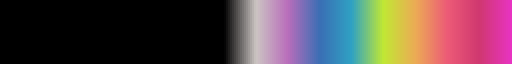

In [44]:
seven = ['Silver']* 1 + ['Fuchsia'] * 1 + ['Denim'] * 1 + ['Cerulean'] * 1 + \
    ['Electric Lime'] * 1 + ['Yellow Orange'] * 1 + ['Radical Red'] * 1 + \
     ['Razzmatazz'] * 1  + ['Hot Magenta']

seven = (['Black'] * (len(seven) - 1)) + seven
seven_pal = sns.crayon_palette(seven)
seven_cmap = sns.blend_palette(sns.color_palette(seven_pal.as_hex(), desat=0.8), as_cmap=True)
seven_cmap

cortex
cortex
cortex


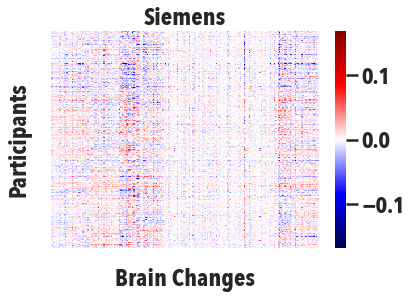

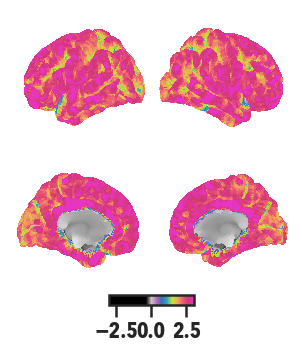

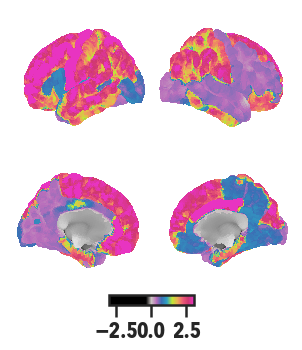

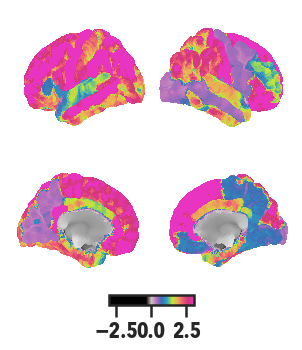

In [45]:
estimator = SpectralBiclustering(
    method='bistochastic',
    n_clusters=(3, 8),
    random_state=1
)
siemens_data = siemens_data[imaging_cols]

siemens_model = estimator.fit(siemens_data)

row_order = pd.Series(siemens_model.row_labels_, index=siemens_data.index)
column_order = pd.Series(siemens_model.column_labels_, index=siemens_data.columns)
row_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'siemens-ppt_clusters-nofmri.pkl'))
column_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'siemens-mri_clusters-nofmri.pkl'))

reordered_rows = siemens_data.loc[row_order.sort_values().index]
reordered_data = reordered_rows[column_order.sort_values().index]
reordered_data.to_csv(join(PROJ_DIR, OUTP_DIR, 'siemens-biclusters-nofmri.csv'))

fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(reordered_data, cmap='seismic', ax=ax, center=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylabel('Participants')
ax.set_xlabel('Brain Changes')
ax.set_title('Siemens')
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'biclustering_grid-siemens-nofmri.png'), bbox_inches='tight', dpi=600)

vmax = estimator.n_clusters[1] + 0.9

one_indexed = column_order + 1

for measure in measures:
    cols = one_indexed.filter(like=measure)
    if len(cols.index) < 0:
        pass
    else:
        cols.name = f'siemens-{measure}-nofmri'
        nifti = series_2_nifti(cols, '../output', save=True)
        plotting.plot_img_on_surf(
            nifti,
            cmap=seven_cmap, 
            threshold=0.00001,
            vmax=3,
            symmetric_cbar=False,
            kwargs={'bg_on_data':True, 'alpha': 0.5, 'avg_method': 'max'},
            #output_file=f'../figures/{cols.name}.png'
        )

In [46]:
column_order[column_order == 3]

dmri_rsirndgm_cdk_pcgrh.change_score    3
dmri_rsirndgm_cdk_cacrh.change_score    3
dmri_rsirndgm_cdk_ttrh.change_score     3
dmri_rsirndgm_cdk_tprh.change_score     3
dmri_rsirndgm_cdk_strh.change_score     3
dmri_rsirnigm_cdk_ttrh.change_score     3
dtype: int32

cortex
cortex
cortex


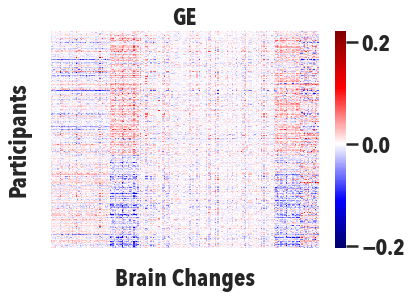

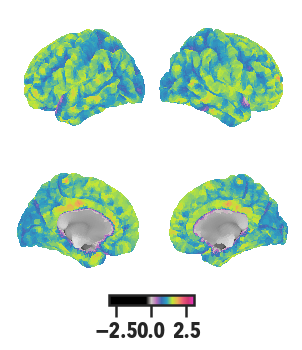

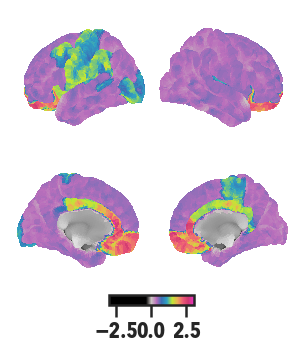

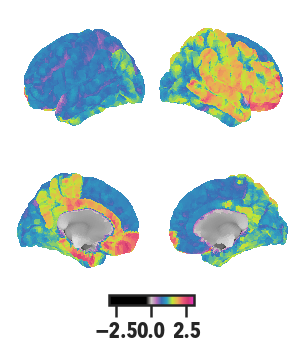

In [47]:
estimator = SpectralBiclustering(

    method='bistochastic',
    n_clusters=(2, 5),
    random_state=1
)
ge_data = ge_data[imaging_cols]
ge_model = estimator.fit(ge_data)

row_order = pd.Series(ge_model.row_labels_, index=ge_data.index)
column_order = pd.Series(ge_model.column_labels_, index=ge_data.columns)
row_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'ge-ppt_clusters-nofmri.pkl'))
column_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'ge-mri_clusters-nofmri.pkl'))

reordered_rows = ge_data.loc[row_order.sort_values().index]
reordered_data = reordered_rows[column_order.sort_values().index]
reordered_data.to_csv(join(PROJ_DIR, OUTP_DIR, 'ge-biclusters-nofmri.csv'))

fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(reordered_data, cmap='seismic', ax=ax, center=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylabel('Participants')
ax.set_xlabel('Brain Changes')
ax.set_title('GE')
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'biclustering_grid-ge-nofmri.png'), bbox_inches='tight', dpi=600)

vmax = estimator.n_clusters[1] + 0.9

one_indexed = column_order + 1

for measure in measures:
    cols = one_indexed.filter(like=measure)
    if len(cols.index) < 0:
        pass
    else:
        cols.name = f'ge-{measure}-nofmri'
        nifti = series_2_nifti(cols, '../output', save=True)
        plotting.plot_img_on_surf(
            nifti,
            cmap=seven_cmap, 
            threshold=0.00001,
            vmax=3,
            symmetric_cbar=False,
            kwargs={'bg_on_data':True, 'alpha': 0.5, 'avg_method': 'max'},
            #output_file=f'../figures/{cols.name}.png'
        )

cortex
cortex
cortex


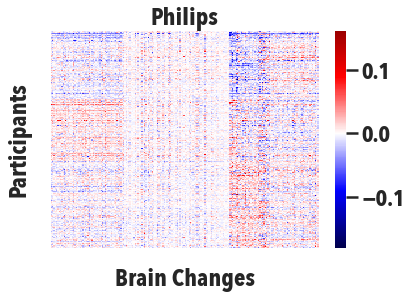

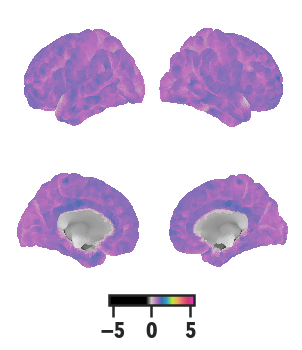

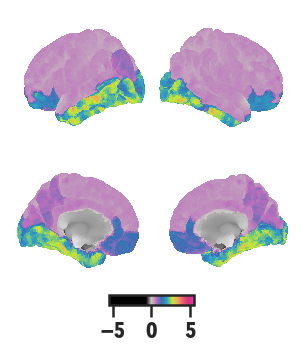

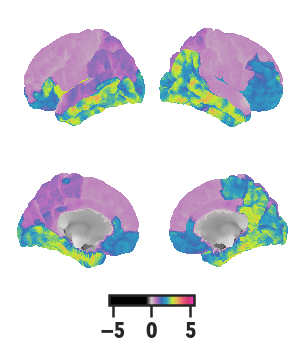

In [48]:
estimator = SpectralBiclustering(
    method='bistochastic',
    n_clusters=(3, 6),
    random_state=1
)
philips_data = philips_data[imaging_cols]
philips_model = estimator.fit(philips_data)

row_order = pd.Series(philips_model.row_labels_, index=philips_data.index)
column_order = pd.Series(philips_model.column_labels_, index=philips_data.columns)
row_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'philips-ppt_clusters-nofmri.pkl'))
column_order.to_pickle(join(PROJ_DIR, OUTP_DIR, 'philips-mri_clusters-nofmri.pkl'))

reordered_rows = philips_data.loc[row_order.sort_values().index]
reordered_data = reordered_rows[column_order.sort_values().index]
reordered_data.to_csv(join(PROJ_DIR, OUTP_DIR, 'philips-biclusters-nofmri.csv'))

fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(reordered_data, cmap='seismic', ax=ax, center=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylabel('Participants')
ax.set_xlabel('Brain Changes')
ax.set_title('Philips')
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'biclustering_grid-philips-nofmri.png'), bbox_inches='tight', dpi=600)

vmax = estimator.n_clusters[1] - .5

one_indexed = column_order + 1

for measure in measures:
    cols = one_indexed.filter(like=measure)
    if len(cols.index) < 0:
        pass
    else:
        cols.name = f'philips-{measure}-nofmri'
        nifti = series_2_nifti(cols, '../output', save=True)
        plotting.plot_img_on_surf(
            nifti,
            cmap=seven_cmap, 
            threshold=0.00001,
            vmax=vmax,
            symmetric_cbar=False,
            kwargs={'bg_on_data':True, 'alpha': 0.5, 'avg_method': 'max'},
            #output_file=f'../figures/{cols.name}.png'
        )

In [49]:
ppt_clusters.unique()

array([0, 1], dtype=int32)

In [50]:
cols = []
for var in numerical:
    columns = df.filter(regex=f'{var}.*', axis=1).columns
    if len(columns) == 0:
        pass
    else:
        for column in columns:
            cols.append(column)
alpha, _= jili_sidak_mc(df[cols], 0.05)

scanners = ['siemens', 'ge', 'philips']
#models = ['', '-nofmri']
stats = ['r', 'p']
groups = [0,1]

clusters = [
    'siemens-0', 'siemens-1', 
    'ge-0', 'ge-1',
    'philips-0', 'philips-1',
]
#index = pd.MultiIndex.from_product([stats, clusters])

outcomes_by_cluster = pd.DataFrame(
    columns=clusters, 
    index=cols,
    dtype=float
)

pvals_by_cluster = pd.DataFrame(
    columns=clusters, 
    index=cols,
    dtype=float
)

sigs = pd.DataFrame(
    columns=clusters, 
    index=cols,
    dtype=str
)
for scanner in scanners:
    #for model in models:
    ppt_clusters = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, f'{scanner}-ppt_clusters-nofmri.pkl'))
    temp = df.loc[ppt_clusters.index]
    dummy_clusters = pd.get_dummies(ppt_clusters)
    for cluster in dummy_clusters.columns:
        for col in cols:
            temp2 = pd.concat([dummy_clusters[cluster], temp[col]], axis=1).dropna()
            if len(temp2[col].index) < 2:
                pass
            else:
                r, p = pointbiserialr(temp2[cluster], temp2[col])
                outcomes_by_cluster.at[col, f'{scanner}-{cluster}'] = r
                pvals_by_cluster.at[col, f'{scanner}-{cluster}'] = p
                if p < alpha:
                    sigs.at[col, f'{scanner}-{cluster}'] = '*'
                else:
                    sigs.at[col, f'{scanner}-{cluster}'] = ''


For 43 vars, number of effective comparisons: 21.76508867624266

Critical value of 0.050 becomes 0.002354 after corrections


In [51]:
sigs

,siemens-0,siemens-1,ge-0,ge-1,philips-0,philips-1,siemens-2,philips-2
interview_age.2_year_follow_up_y_arm_1,,,,,,,,
interview_age.baseline_year_1_arm_1,,,,,,,,
nihtbx_picvocab_uncorrected.baseline_year_1_arm_1,,,,,,,,
nihtbx_picvocab_uncorrected.change_score,,,,,,,,
nihtbx_picvocab_uncorrected.2_year_follow_up_y_arm_1,,,,,,,,
nihtbx_flanker_uncorrected.baseline_year_1_arm_1,,,,,,,,
nihtbx_flanker_uncorrected.change_score,,,,,,,,
nihtbx_flanker_uncorrected.2_year_follow_up_y_arm_1,,,,,,,,
nihtbx_pattern_uncorrected.2_year_follow_up_y_arm_1,,,,,,,,
nihtbx_pattern_uncorrected.baseline_year_1_arm_1,,,,,,,,


In [52]:
cluster_order = ['siemens-0', 'siemens-1', 'siemens-2', 'ge-0', 'ge-1', 'philips-0', 'philips-1', 'philips-2']

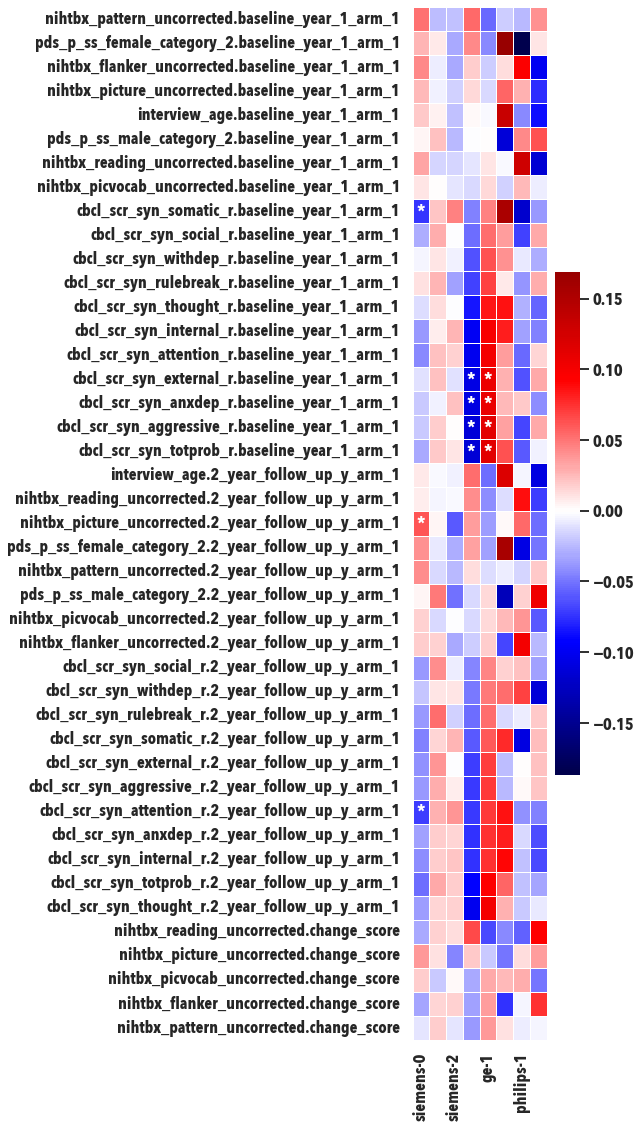

In [53]:
sns.set_context('talk')


nine_ten = outcomes_by_cluster.filter(like='baseline_year_1_arm_1', axis=0).sort_values('ge-0', ascending=False).index
eleven_twelve = outcomes_by_cluster.filter(like='2_year_follow_up_y_arm_1', axis=0).sort_values('ge-0', ascending=False).index
change = outcomes_by_cluster.filter(like='change_score', axis=0).sort_values('ge-0', ascending=False).index

row_order = list(nine_ten) + list(eleven_twelve) + list(change)

fig,ax = plt.subplots(figsize=(3,19))
sns.heatmap(
    outcomes_by_cluster.loc[row_order][cluster_order], 
    cmap='seismic',
    center=0,
    linewidths=1,
    linecolor='w',
    annot=sigs.fillna('').loc[row_order][cluster_order].values,
    fmt=''
)
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'cluster_by_outcome_corrs-nofmri.png'), bbox_inches='tight', dpi=600)

In [54]:
non_numerical = [#"interview_date", 
        "sex", "site_id_l", "demo_prnt_ethn_v2",
        "demo_prnt_marital_v2",
        "demo_prnt_ed_v2",
        "demo_comb_income_v2"]

cols = []
for var in non_numerical:
    columns = df.filter(regex=f'{var}.*', axis=1).columns
    if len(columns) == 0:
        pass
    else:
        for column in columns:
            cols.append(column)

#print(len(cols))
#print(cols)
non_df = df[cols]

cat_alpha,_ = jili_sidak_mc(non_df, 0.05)

stats = ['x2', 'p']
cols = pd.MultiIndex.from_product([scanners, stats])

table = pd.DataFrame(columns=clusters, dtype=float)
props = pd.DataFrame(columns=clusters, dtype=float)
chisq = pd.DataFrame(columns=cols, index=non_df.columns, dtype=float)
sigs = pd.DataFrame(dtype=str)
#print(dat.columns)
for scanner in scanners:
    ppt_clusters = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, f'{scanner}-ppt_clusters-nofmri.pkl'))
    temp = df.loc[ppt_clusters.index]
    for non in non_df.columns:
        dummies = pd.get_dummies(non_df[non])
        #print(dummies.columns)
        small_table = pd.DataFrame(columns=dummies.columns, index=clusters)
        for dumb in dummies.columns:
            if dumb not in [777., 999.]:
                vals = dummies[dumb]
                if vals[temp.index].sum() == 0:
                    pass
                else:
                    dummy_clusters = pd.get_dummies(ppt_clusters)
                    for cluster in dummy_clusters.columns:
                        ppts1 = dummy_clusters[dummy_clusters[cluster] > .1].index
                        one_vals = vals.loc[ppts1]

                        table.at[f'{non}_{dumb}', f'{scanner}-{cluster}'] = one_vals.sum()
                        props.at[f'{non}_{dumb}', f'{scanner}-{cluster}'] = one_vals.sum() / len(ppts1)
                        small_table.at[f'{scanner}-{cluster}', dumb] = one_vals.sum()
        #print(small_table)
        if small_table.sum().sum() > 0:
            x2,p,_,_ = chi2_contingency(small_table.dropna(how='all', axis=1).dropna(how='all', axis=0))
            #print(non, x2, p)
            chisq.at[non, (scanner, 'x2')] = x2
            chisq.at[non, (scanner, 'p')] = p
            if p < cat_alpha:
                sigs.at[non, scanner] = '*'
            else:
                sigs.at[non, scanner] = ''
        else:
            pass
        # do a chi-square test for differences across clusters for each variable.
    #table.dropna(how='all', axis=1).to_csv(join(PROJ_DIR, 'output', f'categorical_vals_by_cluster_{scanner}.csv'))
    #chisq.dropna(how='all', axis=1).to_csv(join(PROJ_DIR, 'output', f'non_numerical_differences_by_cluster_{scanner}.csv'))
chisq.dropna(how='all', inplace=True)
sigs.dropna(how='all', inplace=True)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_9739/942206915.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mc_corrmat = data.corr()



For 8 vars, number of effective comparisons: 3.867795957076392

Critical value of 0.050 becomes 0.013174 after corrections


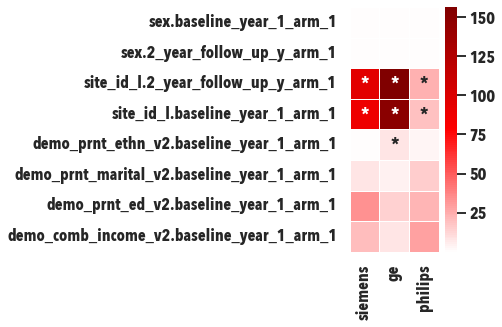

In [55]:
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(2,4.5))
sns.heatmap(
    chisq.swaplevel(axis=1)['x2'], 
    cmap='seismic',
    center=0,
    linewidths=1,
    linecolor='w',
    annot=sigs,
    fmt=''
)
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'all_meas_cat_by_cluster_chisq-nofmri.png'), bbox_inches='tight', dpi=600)

In [56]:
small = sns.crayon_palette(
    [
        'Sunglow',
        'Yellow Orange',
        'Orange',
        'Red Orange', 
        'Radical Red',
        'Razzmatazz',
        'Hot Magenta',
    ],
    
)

small_cmap = sns.color_palette(small.as_hex(), desat=0.8)


small_cmap

[(0.928235294117647, 0.7776470588235294, 0.3541176470588234),
 (0.9258823529411765, 0.6717647058823529, 0.3329411764705882),
 (0.9219607843137255, 0.48901960784313725, 0.2976470588235295),
 (0.9286274509803921, 0.3890196078431371, 0.3576470588235293),
 (0.9286274509803921, 0.3576470588235293, 0.46745098039215677),
 (0.8156862745098037, 0.219607843137255, 0.4392156862745093),
 (0.9113725490196078, 0.20235294117647062, 0.7576470588235296)]

In [57]:
philips_ppt_clustr = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, 'philips-ppt_clusters-nofmri.pkl'))
siemens_ppt_clustr = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, 'siemens-ppt_clusters-nofmri.pkl'))
ge_ppt_clustr = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, 'ge-ppt_clusters-nofmri.pkl'))

In [58]:
philips_mri_clustr = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, 'philips-mri_clusters-nofmri.pkl'))
siemens_mri_clustr = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, 'siemens-mri_clusters-nofmri.pkl'))
ge_mri_clustr = pd.read_pickle(join(PROJ_DIR, OUTP_DIR, 'ge-mri_clusters-nofmri.pkl'))

philips_mri_clustr.name = 'philips'
siemens_mri_clustr.name = 'siemens'
ge_mri_clustr.name = 'ge'

all_clusters = pd.concat([siemens_mri_clustr, ge_mri_clustr, philips_mri_clustr], axis=1)

NDAR_INV07HGA3B7    0
NDAR_INV0DC9BJZK    0
NDAR_INV0DJJP33V    0
NDAR_INV021403LF    0
NDAR_INV0MRY4Z3E    0
                   ..
NDAR_INVZB0WCRDU    0
NDAR_INVXWW4FAU3    0
NDAR_INVZKJXBJMM    0
NDAR_INVVKPJ803Y    0
NDAR_INVVLHZP6FR    0
Name: 0, Length: 2593, dtype: uint8

In [140]:
df['cbcl_scr_syn_anxdep_r.baseline_year_1_arm_1']

subjectkey
NDAR_INV07HGA3B7    5.0
NDAR_INV07RAHHYH    7.0
NDAR_INV08P1JKNE    0.0
NDAR_INV09AUXBBT    2.0
NDAR_INV09ZE6UUK    0.0
                   ... 
NDAR_INVXXHGW734    6.0
NDAR_INVZKJXBJMM    5.0
NDAR_INVZKT1BV8Y    5.0
NDAR_INVVKPJ803Y    3.0
NDAR_INVVLHZP6FR    5.0
Name: cbcl_scr_syn_anxdep_r.baseline_year_1_arm_1, Length: 7326, dtype: float64

In [61]:
mean_regions = assign_region_names(means)

missed 0 regions bc they weren't in the dict


In [146]:
from scipy.stats import mannwhitneyu

clust1ppts = ge_ppt_clustr[ge_ppt_clustr == 0].index
clust3ppts = ge_ppt_clustr[ge_ppt_clustr == 1].index
mannwhitneyu(
    df.loc[clust1ppts]['cbcl_scr_syn_anxdep_r.baseline_year_1_arm_1'],
    df.loc[clust3ppts]['cbcl_scr_syn_anxdep_r.baseline_year_1_arm_1']
)

MannwhitneyuResult(statistic=82747.5, pvalue=0.008225414811290488)

In [145]:
index = pd.MultiIndex.from_product([scanners, ['U', 'p']])
mwu_diffs = pd.DataFrame(columns=)
for var in numerical:
    

NameError: name 'num_df' is not defined

In [64]:
cluster_titles = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

0
1
2
3
4


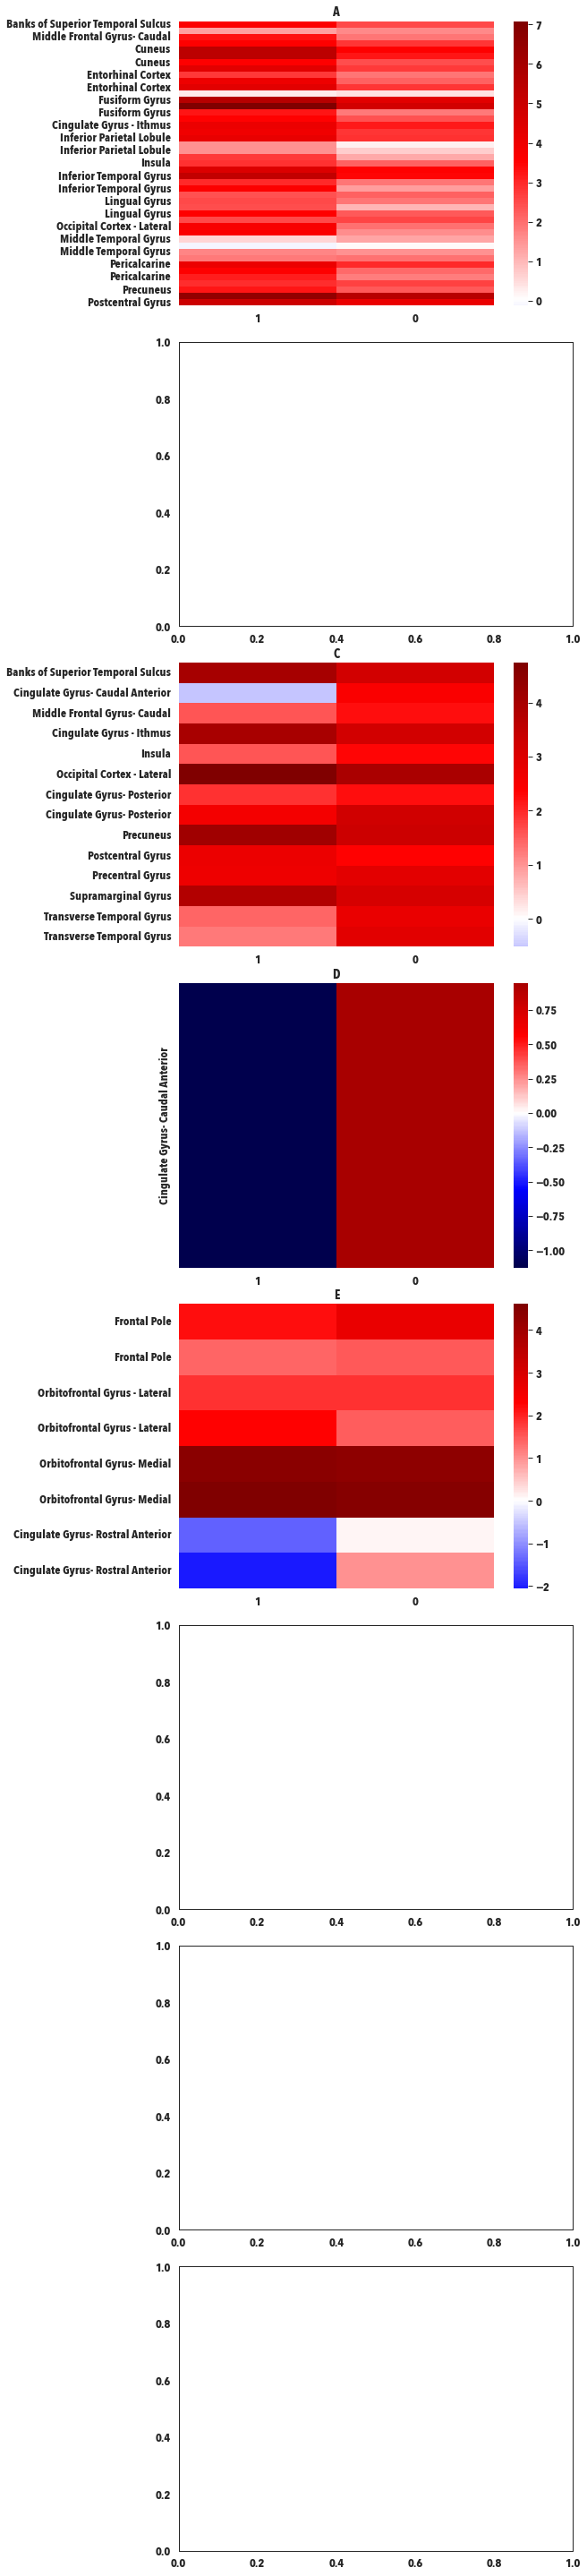

In [99]:
dmri_cols = ge_mri_clustr.filter(like='dmri').index

means = pd.DataFrame(dtype=float)
for i in ge_ppt_clustr.unique():
    ge_0_ppt = ge_ppt_clustr[ge_ppt_clustr == i].index
    temp = df.loc[ge_0_ppt][dmri_cols].mean()
    temp.name = i
    means = pd.concat([means, temp], axis=1)

sns.set_context('paper', font_scale=1.5)
fig,ax = plt.subplots(
    nrows=8, 
    figsize=(7,40), 
    #layout='constrained'
)
plt.tight_layout(pad=1)
for i in ge_mri_clustr.sort_values().unique():
    print(i)
    dat = means.loc[ge_mri_clustr[ge_mri_clustr == i].filter(like='dmri_rsirnigm_cdk').index].sort_index()
    if len(dat.index) == 0:
        pass
    else:
        region_labels = mean_regions.loc[dat.index]['long_region']
        sns.heatmap(
            dat,
            cmap='seismic',
            center=0,
            ax=ax[i]
        )

        labels = [item.get_text() for item in ax[i].get_yticklabels()]
        # Beat them into submission and set them back again
        ax[i].set_yticklabels([region_labels[labels.index(label)] for label in labels])
        ax[i].set_title(cluster_titles[i])

plt.show()

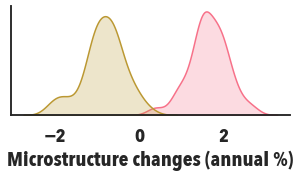

In [135]:
sns.set_theme(
    context='talk', 
    style='white', 
    palette='husl', 
    font="Avenir Next Condensed",
    font_scale=1.15
)
fig,ax = plt.subplots(figsize=(5,2))
sns.kdeplot(
    df.filter(
        regex="dmri_rsirnigm.*change_score",
        axis=1).mean(axis=0).values.flatten(),
    fill=True,
    ax=ax
)
sns.kdeplot(
    df.filter(
        regex="dmri_rsirndgm.*change_score", 
        axis=1).mean(axis=0).values.flatten(), 
    fill=True,
    ax=ax
)
ax.set_xlabel('Microstructure changes (annual %)')
ax.set_ylabel('')
ax.set_yticks([])
sns.despine()
fig.savefig('../figures/APD_RSI.png', bbox_inches='tight', dpi=600)

In [115]:
df.filter(regex="dmri_rsirndgm.*change_score", axis=1).mean(axis=0)

dmri_rsirndgm_cdk_bstslh.change_score   -0.900675
dmri_rsirndgm_cdk_caclh.change_score    -2.030243
dmri_rsirndgm_cdk_cmflh.change_score    -0.952911
dmri_rsirndgm_cdk_cnlh.change_score     -0.117298
dmri_rsirndgm_cdk_erlh.change_score     -0.838363
                                           ...   
dmri_rsirndgm_cdk_smrh.change_score     -0.567130
dmri_rsirndgm_cdk_fprh.change_score     -1.082973
dmri_rsirndgm_cdk_tprh.change_score      0.057576
dmri_rsirndgm_cdk_ttrh.change_score     -1.000879
dmri_rsirndgm_cdk_isrh.change_score     -1.730852
Length: 68, dtype: float64

In [147]:
from scipy.stats import spearmanr


sa_rni_corrs = pd.DataFrame()
for i in df.index:
    temp1 = df.loc[i][brain_region_list]
    temp1.name = 'ppt'
    temp2 = sa_axis_df[sa_col]
    temp2.name = 'sa_axis'
    temp = pd.concat([temp1, temp2], axis=1)
    r,p = spearmanr(temp['ppt'], temp['sa_axis'])
    sa_rni_corrs.at[i,'p'] = p
    sa_rni_corrs.at[i,'r'] = r

,cbcl_scr_syn_internal_r.2_year_follow_up_y_arm_1,cbcl_scr_syn_anxdep_r.2_year_follow_up_y_arm_1,site_id_l.2_year_follow_up_y_arm_1,demo_prnt_marital_v2.baseline_year_1_arm_1,nihtbx_cardsort_uncorrected.2_year_follow_up_y_arm_1,race_ethnicity.2_year_follow_up_y_arm_1,cbcl_scr_syn_rulebreak_r.2_year_follow_up_y_arm_1,cbcl_scr_syn_aggressive_r.baseline_year_1_arm_1,nihtbx_picture_uncorrected.2_year_follow_up_y_arm_1,cbcl_scr_syn_totprob_r.2_year_follow_up_y_arm_1,...,dmri_rsirndgm_cdk_fprh.change_score,dmri_rsirndgm_cdk_tprh.baseline_year_1_arm_1,dmri_rsirndgm_cdk_tprh.2_year_follow_up_y_arm_1,dmri_rsirndgm_cdk_tprh.change_score,dmri_rsirndgm_cdk_ttrh.baseline_year_1_arm_1,dmri_rsirndgm_cdk_ttrh.2_year_follow_up_y_arm_1,dmri_rsirndgm_cdk_ttrh.change_score,dmri_rsirndgm_cdk_isrh.baseline_year_1_arm_1,dmri_rsirndgm_cdk_isrh.2_year_follow_up_y_arm_1,dmri_rsirndgm_cdk_isrh.change_score
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INV07HGA3B7,NaN,NaN,site16,1.0,NaN,NaN,NaN,9.0,111.0,NaN,...,-1.495827,0.201515,0.228395,5.174299,0.240827,0.249394,1.446292,0.230891,0.228409,-0.447220
NDAR_INV07RAHHYH,7.0,5.0,site08,1.0,NaN,NaN,0.0,5.0,109.0,20.0,...,-7.704083,0.283384,0.270676,-2.201779,0.350575,0.229034,-20.130798,0.317332,0.258218,-9.860117
NDAR_INV08P1JKNE,3.0,3.0,site17,1.0,NaN,NaN,0.0,1.0,108.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NDAR_INV09AUXBBT,2.0,1.0,site13,1.0,NaN,NaN,0.0,0.0,111.0,5.0,...,-16.931353,0.271606,0.243547,-5.683531,0.273046,0.262964,-1.962751,0.317134,0.251209,-12.103738
NDAR_INV09ZE6UUK,0.0,0.0,site15,2.0,NaN,NaN,1.0,6.0,NaN,7.0,...,-6.143729,0.201367,0.239739,9.077285,0.186451,0.193132,1.836558,0.242761,0.224377,-4.106572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVXXHGW734,13.0,10.0,site02,1.0,NaN,NaN,0.0,7.0,115.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NDAR_INVZKJXBJMM,10.0,7.0,site16,1.0,NaN,NaN,0.0,4.0,117.0,13.0,...,-1.236300,0.226927,0.251251,5.086822,0.239110,0.302367,11.682454,0.220470,0.257333,7.715301
NDAR_INVZKT1BV8Y,5.0,1.0,site14,1.0,NaN,NaN,2.0,0.0,125.0,9.0,...,-5.016136,0.246864,0.267121,3.783498,0.241014,0.227326,-2.805907,0.225827,0.239225,2.765813


In [154]:
var = 'dmri_rsirndgm_cdk_ttrh.change_score'
var.split('.')[0].split('_')[-1]

'ttrh'

In [156]:
list_ = df.filter(regex='dmri_rsirndgm_.*change_score').columns
[var.split('.')[0].split('_')[-1] for var in list_]

['bstslh',
 'caclh',
 'cmflh',
 'cnlh',
 'erlh',
 'fflh',
 'iplh',
 'itlh',
 'iclh',
 'lolh',
 'loflh',
 'lglh',
 'moflh',
 'mtlh',
 'phlh',
 'pclh',
 'poplh',
 'poblh',
 'ptglh',
 'pcclh',
 'pctlh',
 'pcglh',
 'prctlh',
 'prcnlh',
 'raclh',
 'rmflh',
 'sflh',
 'splh',
 'stlh',
 'smlh',
 'fplh',
 'tplh',
 'ttlh',
 'islh',
 'bstsrh',
 'cacrh',
 'cmfrh',
 'cnrh',
 'errh',
 'ffrh',
 'iprh',
 'itrh',
 'icrh',
 'lorh',
 'lofrh',
 'lgrh',
 'mofrh',
 'mtrh',
 'phrh',
 'pcrh',
 'poprh',
 'pobrh',
 'ptgrh',
 'pccrh',
 'pctrh',
 'pcgrh',
 'prctrh',
 'prcnrh',
 'racrh',
 'rmfrh',
 'sfrh',
 'sprh',
 'strh',
 'smrh',
 'fprh',
 'tprh',
 'ttrh',
 'isrh']

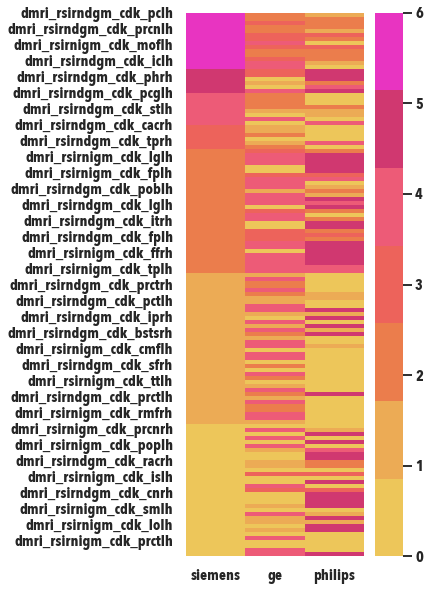

In [58]:
all_clusters = pd.concat([siemens_mri_clustr, ge_mri_clustr, philips_mri_clustr], axis=1)

sns.set_context('talk', font_scale=0.9)
fig,ax = plt.subplots(figsize=(4,10))
sns.heatmap(all_clusters.sort_values('siemens',ascending=False).filter(like='dmri', axis=0), cmap=small_cmap, ax=ax)
labels = [item.get_text() for item in ax.get_yticklabels()]
# Beat them into submission and set them back again
ax.set_yticklabels([str(label).split('.')[0] for label in labels])
plt.show()

In [59]:
all_clusters = assign_region_names(all_clusters)

missed 0 regions bc they weren't in the dict


In [ ]:
all_clusters.sort_values('siemens')

In [ ]:
spearman_brain_df = pd.DataFrame(
    index=brain_df.columns,
    columns=pd.MultiIndex.from_product([siemens_df, ['r', 'p']])
    )

temp = brain_df.loc[siemens_df.index]
for column in brain_df.columns:
    for component in siemens_df.columns:
        double_temp = pd.concat([temp[column], siemens_df[component]], axis=1).dropna()
        if component == 2:
            r,p = pointbiserialr(double_temp[component], double_temp[column])
            spearman_brain_df.at[column, (component, 'r')] = r
            spearman_brain_df.at[column, (component, 'p')] = p
        else:
            r,p = spearmanr(double_temp[component], double_temp[column])
            spearman_brain_df.at[column, (component, 'r')] = r
            spearman_brain_df.at[column, (component, 'p')] = p

In [ ]:
spearman_brain_ge_df = pd.DataFrame(
    index=brain_df.columns,
    columns=pd.MultiIndex.from_product([ge_df, ['r', 'p']])
    )

temp = brain_df.loc[ge_df.index]
for column in brain_df.columns:
    for component in ge_df.columns:
        double_temp = pd.concat([temp[column], ge_df[component]], axis=1).dropna()
        if component == 2:
            r,p = pointbiserialr(double_temp[component], double_temp[column])
            spearman_brain_ge_df.at[column, (component, 'r')] = r
            spearman_brain_ge_df.at[column, (component, 'p')] = p
        else:
            r,p = spearmanr(double_temp[component], double_temp[column])
            spearman_brain_ge_df.at[column, (component, 'r')] = r
            spearman_brain_ge_df.at[column, (component, 'p')] = p

In [ ]:
spearman_brain_ge_df

In [ ]:
scanners = {'ge': ge_df, 
            #'philips': philips_df, 
            'siemens': siemens_df}

for scanner in scanners.keys():
    # find the smaller cluster
    print(scanner)
    dat = scanners[scanner]
    ppt_per_clust = dat.sum()
    ppt_per_clust = ppt_per_clust[ppt_per_clust > 0]
    dat = dat[ppt_per_clust.index]
    #print(dat.head())
    print(dat.sum())
    #small = dat.sum().argmin()
    dat.columns = [f'{scanner}-{col}' for col in dat.columns]
    #large = dat.sum().argmax()
    #list_ = ['', '']
    #list_[small] = 'small'
    #list_[large] = 'large'
    #dat.columns = list_
    #print(dat.columns)
    alpha, _ = jili_sidak_mc(num_df, 0.05)

    stats = ['t', 'p']
    clusts = dat.columns
    index = pd.MultiIndex.from_product([stats, clusts, clusts])
    print(index)
    numerical_stats = pd.DataFrame(columns=index, 
                                index=num_df.columns)
    for num in num_df.columns:
        for cluster1 in dat.columns:
            ppts1 = dat[dat[cluster1] > .1].index
            for cluster2 in dat.columns:
                if cluster2 != cluster1:
                    ppts2 = dat[dat[cluster2] > .1].index
                    one_vals = num_df.loc[ppts1][num].dropna()
                    two_vals = num_df.loc[ppts2][num].dropna()

                    t, p = ttest_ind(one_vals, two_vals)
                    numerical_stats.at[num, ('t', cluster1, cluster2)] = t
                    numerical_stats.at[num, ('p', cluster1, cluster2)] = p

        if p < alpha:
            print(num, np.round(t, 2), np.round(p, 3))
    numerical_stats
    numerical_stats.dropna(how='all', axis=1).to_csv(join(PROJ_DIR, OUTP_DIR, f'numerical_differences_by_cluster_{scanner}.csv'))

    stats = ['x2', 'p']
    index = pd.MultiIndex.from_product([stats, clusts, clusts])
    
    table = pd.DataFrame(columns=dat.columns)
    chisq = pd.DataFrame(columns=['x2', 'p'], index=non_df.columns)
    #print(dat.columns)
    for non in non_df.columns:
        dummies = pd.get_dummies(non_df[non])
        #print(dummies.columns)
        small_table = pd.DataFrame(columns=dummies.columns, index=dat.columns)
        for dumb in dummies.columns:
            vals = dummies[dumb]
            
            if vals[dat.index].sum() == 0:
                pass
            else:
                for cluster in dat.columns:
                    ppts1 = dat[dat[cluster] > .1].index
                    one_vals = vals.loc[ppts1]
                    
                    table.at[f'{non}_{dumb}', cluster] = one_vals.sum()
                    small_table.at[cluster, dumb] = one_vals.sum()
        #print(small_table)
        if small_table.sum().sum() > 0:
            x2,p,_,_ = chi2_contingency(small_table.dropna(how='all', axis=1).dropna(how='all', axis=0))
            #print(non, x2, p)
            chisq.at[non, ('x2')] = x2
            chisq.at[non, ('p')] = p
        else:
            pass
        # do a chi-square test for differences across clusters for each variable.
    table.dropna(how='all', axis=1).to_csv(join(PROJ_DIR, 'output', f'categorical_vals_by_cluster_{scanner}.csv'))
    chisq.dropna(how='all', axis=1).to_csv(join(PROJ_DIR, 'output', f'non_numerical_differences_by_cluster_{scanner}.csv'))

In [ ]:
siemens_numbers = pd.read_csv(join(PROJ_DIR, OUTP_DIR, 'numerical_corrs_by_cluster_SIEMENS.csv'), index_col=0, header=[0,1])
ge_numbers = pd.read_csv(join(PROJ_DIR, OUTP_DIR, 'numerical_corrs_by_cluster_GE MEDICAL SYSTEMS.csv'), index_col=0, header=[0,1])
#philips_numbers = pd.read_csv(join(PROJ_DIR, OUTP_DIR, 'numerical_corrs_by_cluster_philips.csv'), index_col=0, header=[0,1])

In [ ]:
long_names = {
    'picvocab': 'Picture Vocabulary',
    'flanker': 'Inhibitory Control',
    'cardsort': 'Card Sorting',
    'list': 'List Sorting',
    'pattern': 'Pattern Comparison',
    'picture': 'Picture Sequence',
    'reading': 'Reading Recognition',
    'totprob': 'Total Problems',
    'anxdep': 'Anxious/Depressed',
    'withdep': 'Withdrawn',
    'somatic': 'Somatic Complaints',
    'thought': 'Thought Problems',
    'rulebreak': 'Rule Breaking',
    'aggressive': 'Aggressive',
    'internal': 'Internalizing',
    'external': 'Externalizing',
    'age': 'Age',
    'female': 'Female Puberty',
    'male': 'Male Puberty',
    'social': 'Social Problems',
    'attention': 'Attention Problems'
    }

In [ ]:
mega_df = pd.concat(
    [
        siemens_numbers, 
        ge_numbers, 
        #philips_numbers
    ], axis=1)
for i in mega_df.index:
    vars_ = i.split('.')
    timepoint = vars_[-1]
    if '2' in timepoint:
        mega_df.at[i, 'timepoint'] = 'at 11-13 years'
    elif 'change' in timepoint:
        mega_df.at[i, 'timepoint'] = 'change 9-13 years'
    else:
        mega_df.at[i, 'timepoint'] = 'at 9-10 years'
    if 'cbcl' in i:
        mega_df.at[i, 'instrument'] = vars_[0].split('_')[0]
        measure = vars_[0].split('_')[3]
        mega_df.at[i, 'measure'] = long_names[measure]
    elif 'pds' in i:
        mega_df.at[i, 'instrument'] = vars_[0].split('_')[0]
        measure = vars_[0].split('_')[3]
        mega_df.at[i, 'measure'] = long_names[measure]
    else:
        mega_df.at[i, 'instrument'] = vars_[0].split('_')[0]
        measure = vars_[0].split('_')[1]
        mega_df.at[i, 'measure'] = long_names[measure]
    mega_df.at[i, 'var'] = f'{mega_df.loc[i][("measure", "")]} {mega_df.loc[i][("timepoint", "")]}'

In [ ]:
mega_df = mega_df.swaplevel(axis=1)


In [ ]:
sns.kdeplot(data=num_df, x='cbcl_scr_syn_withdep_r.baseline_year_1_arm_1')


In [ ]:
mega_df

In [ ]:
num_df.describe()


In [ ]:
order = [
    'SIEMENS_22',
    'SIEMENS_5', 
    'SIEMENS_21', 
    'GE MEDICAL SYSTEMS_4',
    'GE MEDICAL SYSTEMS_10',  
    'timepoint',
    'instrument',
    'measure',
    'var']


In [ ]:
sns.set_context('talk')
temp = mega_df[['r', '']].droplevel(0, axis=1)[order]

nine_ten = temp[temp['timepoint'] == 'at 9-10 years'].sort_values('SIEMENS_22', ascending=False).index
eleven_twelve = temp[temp['timepoint'] == 'at 11-13 years'].sort_values('SIEMENS_22', ascending=False).index
change = temp[temp['timepoint'] == 'change 9-13 years'].sort_values('SIEMENS_22', ascending=False).index

row_order = list(nine_ten) + list(eleven_twelve) + list(change)


# Make the PairGrid
g = sns.PairGrid(temp.loc[row_order],
                 x_vars=temp.columns[:-6], y_vars=["var"],
                 height=11, aspect=.25, hue="instrument", palette="hls", 
                 hue_order=['nihtbx', 'interview', 'cbcl', 'pds'])

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.25, 0.25), xlabel="r", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['High cognition,\nlow psychopathology', 'Low cognition,\nhigh psychopathology', 'None\nsignificant']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.axvline(0, lw=1, ls='--', color='#333333', alpha=0.5)
g.axes.flat[-1].legend(bbox_to_anchor=[1,1])
sns.despine(left=True, bottom=True)

In [ ]:
g.figure.savefig('../figures/numerical_corrs_siemens.png', dpi=600, bbox_inches='tight')


In [ ]:
temp = temp[order]

nine_ten = temp[temp['timepoint'] == 'at 9-10 years'].sort_values('GE MEDICAL SYSTEMS_4', ascending=False).index
eleven_twelve = temp[temp['timepoint'] == 'at 11-13 years'].sort_values('GE MEDICAL SYSTEMS_4', ascending=False).index
change = temp[temp['timepoint'] == 'change 9-13 years'].sort_values('GE MEDICAL SYSTEMS_4', ascending=False).index

row_order = list(nine_ten) + list(eleven_twelve) + list(change)


# Make the PairGrid
g = sns.PairGrid(temp.loc[row_order],
                 x_vars=temp.columns[3:-4], y_vars=["var"],
                 height=11, aspect=.25, hue="instrument", palette="hls", 
                 hue_order=['nihtbx', 'interview', 'cbcl', 'pds'])

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-1, 1), xlabel="r", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['High list sort,\nlow card sort', 'Low list sort,\nhigh card sort', 'Low\ncard sort']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.axvline(0, lw=1, ls='--', color='#333333', alpha=0.5)
g.axes.flat[-1].legend(bbox_to_anchor=[1,1])
sns.despine(left=True, bottom=True)
g.figure.savefig(join('..', FIGS_DIR, 'numerical_corrs_ge.png'), dpi=600, bbox_inches='tight')

In [ ]:
temp = temp[order]

nine_ten = temp[temp['timepoint'] == 'at 9-10 years'].sort_values('siemens-14', ascending=False).index
eleven_twelve = temp[temp['timepoint'] == 'at 11-13 years'].sort_values('siemens-14', ascending=False).index
change = temp[temp['timepoint'] == 'change 9-13 years'].sort_values('siemens-14', ascending=False).index

row_order = list(nine_ten) + list(eleven_twelve) + list(change)

# Make the PairGrid
g = sns.PairGrid(temp.loc[row_order],
                 x_vars=temp.columns[6:-4], y_vars=["var"],
                 height=11, aspect=.25, hue="instrument", palette="hls",
                 hue_order=['nihtbx', 'interview', 'cbcl', 'pds'])

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-1, 1), xlabel="r", ylabel="temp['measure']")

# Use semantically meaningful titles for the columns
titles = ['High list sort,\nlow card sort', 'Low list sort,\nhigh card sort', 'Low\ncard sort']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.axvline(0, lw=1, ls='--', color='#333333', alpha=0.5)
g.axes.flat[-1].legend(bbox_to_anchor=[1,1])
sns.despine(left=True, bottom=True)
#g.figure.savefig(join(PROJ_DIR, FIGS_DIR, 'numerical_corrs_ge.png'), dpi=600, bbox_inches='tight')

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()


In [ ]:
sns.set_context('poster')


In [ ]:
def plot_surfaces(nifti, surf, cmap, vmax, threshold):
    '''
    Plots of medial and lateral left and right surface views from nifti volume
    '''
    from matplotlib.gridspec import GridSpec
    import matplotlib as mpl
    
    texture_l = surface.vol_to_surf(nifti, 
                                    surf.white_left, 
                                    interpolation='nearest', n_samples=160)
    texture_r = surface.vol_to_surf(nifti, surf.white_right, 
                                    interpolation='nearest', n_samples=160)
    
    fig = plt.figure(figsize=(12,3))
    gs = GridSpec(1, 4)

    ax0 = fig.add_subplot(gs[0], projection='3d')
    ax1 = fig.add_subplot(gs[1], projection='3d')
    ax2 = fig.add_subplot(gs[2], projection='3d')
    ax3 = fig.add_subplot(gs[3], projection='3d')
    
    plt.tight_layout(w_pad=-8, h_pad=-10)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         bg_map=surf.sulc_left,
                                         symmetric_cbar=False, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax0, darkness=1)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         bg_map=surf.sulc_left,
                                         symmetric_cbar=False, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax1)
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         bg_map=surf.sulc_right,
                                         symmetric_cbar=False, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax2)
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         bg_map=surf.sulc_right,
                                         symmetric_cbar=False, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax3)
    #cb = mpl.colorbar.ColorbarBase(ax4, orientation='vertical', 
    #                           cmap=cmap, 
    #                           values=range(-vmax,vmax), 
    #                          )
    #plt.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax3, cmap=cmap, values=range(-vmax,vmax))
    #mpl.colorbar.make_axes_gridspec(ax3,
    #                                location='right', 
    #                                orientation='vertical', 
    #                                fraction=0.15, 
    #                                shrink=0.7, 
    #                                aspect=20, cmap='bwr', values=range(-vmax,vmax))
    return fig

In [ ]:
plot_surfaces(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-thickness-ge-2-thick.nii', 
    fsaverage, cmap='bwr', threshold=2.7, vmax=None)

In [ ]:
measures = {
    'thickness': 'thick',
    'RNI': 'rni', 
    'RND': 'rnd',
    'BOLD-variance': 'var'
}

ge_clusters = ['2', '6', '26']

for measure in measures.keys():
    for cluster in ge_clusters:
        plotting.plot_img_on_surf(
            join(PROJ_DIR, FIGS_DIR,f'cortical-{measure}-ge-{cluster}-{measures[measure]}.nii'),
            cmap='bwr', 
            threshold=3.36, 
            symmetric_cbar=True, 
            output_file=f'../figures/cortical-{measure}-ge-{cluster}-{measures[measure]}.png')

In [ ]:
measures = {
    'thickness': 'thick',
    'RNI': 'rni', 
    'RND': 'rnd',
    'BOLD-variance': 'var'
}

siemens_clusters = ['14', '23', '2']

for measure in measures.keys():
    for cluster in siemens_clusters:
        plotting.plot_img_on_surf(
            join(PROJ_DIR, FIGS_DIR,f'cortical-{measure}-siemens-{cluster}-{measures[measure]}.nii'),
            cmap='bwr', 
            threshold=3.36, 
            symmetric_cbar=True, 
            output_file=f'../figures/cortical-{measure}-siemens-{cluster}-{measures[measure]}.png')

In [ ]:
k = plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-RNI-siemens-14-rni.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-RNI-siemens-14-rni.png')

In [ ]:
k = plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-RNI-siemens-23-rni.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-RNI-siemens-23-rni.png')

In [ ]:
k = plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-RNI-siemens-2-rni.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-RNI-siemens-2-rni.png')

In [ ]:
k = plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-BOLD-variance-siemens-2-var.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-BOLD-variance-siemens-2-var.png')

In [ ]:
k = plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-BOLD-variance-siemens-14-var.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-BOLD-variance-siemens-14-var.png')

In [ ]:
k = plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-BOLD-variance-siemens-23-var.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-BOLD-variance-siemens-23-var.png')

In [ ]:
plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-RND-siemens-14-rnd.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-RND-siemens-14-rnd.png')

plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-RND-siemens-23-rnd.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-RND-siemens-23-rnd.png')

plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-RND-siemens-2-rnd.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-RND-siemens-2-rnd.png')

In [ ]:
plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-thickness-siemens-14-thick.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-thickness-siemens-14-thick.png')

plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-thickness-siemens-23-thick.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-thickness-siemens-23-thick.png')

plotting.plot_img_on_surf(
    '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_vbgmm/figures/cortical-thickness-siemens-2-thick.nii',
    cmap='bwr', threshold=2.7, symmetric_cbar=True, output_file='../figures/cortical-thickness-siemens-2-thick.png')